# New York City Restaurant Analysis
In this notebook, we will analyze the restaurants in the neighbourhoods of New York City and find the best place to open a new restaurant.

We will need a list of New York neighbourhoods, restaurants in these neighbourhoods and their details.

## Table of Contents
1. Data Collection and Cleaning  
1.1. Get neighbourhood data  
1.2. Add location information to neighbourhoods  
1.3. Fetch restaurants from each neighbourhood  
1.4. Fetch venues near each restaurant  
2. Modeling  
2.1. Feature selection  
2.2. Feature Normalization  
2.3. Clustering  
3. Results  
4. Conclusion

## 1. Data Collection and Cleaning
### 1.1. Get neighbourhood data
Let's start by getting the list of neighbourhoods in New York City. We will scrape the data that we need from the Wikipedia page, [Neighborhoods in New York City](https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City).

We will use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to scrape the data from the web page and put it into a pandas dataframe.

In [1]:
# Import libraries
try:
    from bs4 import BeautifulSoup
except:
    !conda install -c conda-forge beautifulsoup4 --yes
    from bs4 import BeautifulSoup

import pandas as pd
import requests

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Get the html content from the web page and pass it to the BeautifulSoup constructor.

In [2]:
url = "https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City"

page = requests.get(url).text
soup = BeautifulSoup(page, "lxml")

# Print the title of the web page
print(soup.title.string)

Neighborhoods in New York City - Wikipedia


The  wikipedia page has a table of community areas with neighbourhoods in each area. We will transform the individual neighbourhoods into separate columns.

In [3]:
import unicodedata
import re

# Extract the HTML table
community_areas_table = soup.find("table", {"class": "wikitable sortable"})

community_areas = []
pattern = "(\[\d+\])+"

# Get the table headers
headers = community_areas_table.findAll("th")
headers = [h.text.replace("\n", "") for h in headers]

# Loop through the table rows and extract the text of the elements
for row in community_areas_table.findAll("tr"):
    columns = row.findAll("td")
    if len(columns) > 0:
        area = {}
        for index in range(len(columns)):
            normalized = unicodedata.normalize("NFKD", columns[index].text.replace("\n", ""))
            matches = re.search(pattern, normalized)
            if matches is not None:
                normalized = normalized.replace(matches.group(0), "")
            area[headers[index]] = normalized
        community_areas.append(area)

In [4]:
community_areas[0:2]

[{'Community Board(CB)': 'Bronx CB 1',
  'Areakm2': '7.17',
  'Pop.Census2010': '91,497',
  'Pop./km2': '12,761',
  'Neighborhoods': 'Melrose, Mott Haven, Port Morris'},
 {'Community Board(CB)': 'Bronx CB 2',
  'Areakm2': '5.54',
  'Pop.Census2010': '52,246',
  'Pop./km2': '9,792',
  'Neighborhoods': 'Hunts Point, Longwood'}]

In [5]:
import numpy as np


def get_borough(comm_board):
    matches = re.search("(\sCB\s\d+)", comm_board)
    if matches is not None:
        to_replace = matches.group(0)
    else:
        to_replace = comm_board
    result = comm_board.replace(to_replace, "")
    return result


# Create pandas dataframe
ny_communities = pd.DataFrame(community_areas)
ny_communities.columns = ["Area (km2)", "Community Board", "Neighbourhoods", "Pop. / km2", "Pop. Census (2010)"]

# Drop unwanted columns
ny_communities = ny_communities[ny_communities.columns[1:3]]

# Split Neighbourhoods
ny_communities["Neighbourhoods"] = ny_communities["Neighbourhoods"].apply(lambda c: c.split(", "))
neigh_length = [len(neigh) for neigh in ny_communities["Neighbourhoods"]]
ny_communities = pd.DataFrame({
    "Community Board" : np.repeat(ny_communities["Community Board"].values, neigh_length),
    "Neighbourhood" : np.concatenate(ny_communities["Neighbourhoods"].values)
})

# Create a Borough column
ny_communities["Borough"] = ny_communities["Community Board"].apply(get_borough)

# Rearrage columns
fixed_columns = [ny_communities.columns[-1]] + list(ny_communities.columns[:-1])
ny_communities = ny_communities[fixed_columns]

ny_communities.head()

Borough Community Board Neighbourhood
0   Bronx      Bronx CB 1       Melrose
1   Bronx      Bronx CB 1    Mott Haven
2   Bronx      Bronx CB 1   Port Morris
3   Bronx      Bronx CB 2   Hunts Point
4   Bronx      Bronx CB 2      Longwood

In [6]:
ny_communities.groupby("Borough").count()

Community Board  Neighbourhood
Borough                                      
                             1              1
Bronx                       60             60
Brooklyn                    79             79
Manhattan                   45             45
Queens                      86             86
Staten Island               56             56

In [7]:
ny_communities[ny_communities["Borough"] == ""]

Borough Community Board Neighbourhood
326           New York City

Delete the row without a Borough name.

In [8]:
ny_communities = ny_communities.drop(index=ny_communities[ny_communities["Borough"] == ""].index, axis=0)

ny_communities.groupby("Borough").count()

Community Board  Neighbourhood
Borough                                      
Bronx                       60             60
Brooklyn                    79             79
Manhattan                   45             45
Queens                      86             86
Staten Island               56             56

We will choose the neighbourhoods from one Borough for this analysis. Let's choose Manhattan.

In [9]:
manhattan_neighbourhoods = ny_communities[ny_communities["Borough"] == "Manhattan"].reset_index(drop=True)
print("Number of rows in dataframe: ", manhattan_neighbourhoods.shape[0])
print("Number of unique neighbourhoods: ", len(manhattan_neighbourhoods["Neighbourhood"].unique().tolist()))

manhattan_neighbourhoods

Number of rows in dataframe:  45
Number of unique neighbourhoods:  43


Borough  Community Board         Neighbourhood
0   Manhattan   Manhattan CB 1     Battery Park City
1   Manhattan   Manhattan CB 1    Financial District
2   Manhattan   Manhattan CB 1               TriBeCa
3   Manhattan   Manhattan CB 2             Chinatown
4   Manhattan   Manhattan CB 2     Greenwich Village
5   Manhattan   Manhattan CB 2          Little Italy
6   Manhattan   Manhattan CB 2       Lower East Side
7   Manhattan   Manhattan CB 2                  NoHo
8   Manhattan   Manhattan CB 2                  SoHo
9   Manhattan   Manhattan CB 2          West Village
10  Manhattan   Manhattan CB 3         Alphabet City
11  Manhattan   Manhattan CB 3             Chinatown
12  Manhattan   Manhattan CB 3          East Village
13  Manhattan   Manhattan CB 3       Lower East Side
14  Manhattan   Manhattan CB 3           Two Bridges
15  Manhattan   Manhattan CB 4               Chelsea
16  Manhattan   Manhattan CB 4               Clinton
17  Manhattan   Manhattan CB 5               Midtown
18  Manhattan   Manhattan CB 6         Gramercy Park
19  Manhattan   Manhattan CB 6              Kips Bay
20  Manhattan   Manhattan CB 6           Murray Hill
21  Manhattan   Manhattan CB 6  Peter Cooper Village
22  Manhattan   Manhattan CB 6       Stuyvesant Town
23  Manhattan   Manhattan CB 6          Sutton Place
24  Manhattan   Manhattan CB 6            Tudor City
25  Manhattan   Manhattan CB 6            Turtle Bay
26  Manhattan   Manhattan CB 6       Waterside Plaza
27  Manhattan   Manhattan CB 7        Lincoln Square
28  Manhattan   Manhattan CB 7      Manhattan Valley
29  Manhattan   Manhattan CB 7       Upper West Side
30  Manhattan   Manhattan CB 8            Lenox Hill
31  Manhattan   Manhattan CB 8      Roosevelt Island
32  Manhattan   Manhattan CB 8       Upper East Side
33  Manhattan   Manhattan CB 8             Yorkville
34  Manhattan   Manhattan CB 9      Hamilton Heights
35  Manhattan   Manhattan CB 9        Manhattanville
36  Manhattan   Manhattan CB 9   Morningside Heights
37  Manhattan  Manhattan CB 10                Harlem
38  Manhattan  Manhattan CB 10          Polo Grounds
39  Manhattan  Manhattan CB 11           East Harlem
40  Manhattan  Manhattan CB 11      Randall’s Island
41  Manhattan  Manhattan CB 11        Spanish Harlem
42  Manhattan  Manhattan CB 11          Wards Island
43  Manhattan  Manhattan CB 12                Inwood
44  Manhattan  Manhattan CB 12    Washington Heights

In [10]:
# Drop duplicate rows
manhattan_neighbourhoods = manhattan_neighbourhoods.drop_duplicates(subset="Neighbourhood")
manhattan_neighbourhoods.shape

(43, 3)

### 1.2. Add location information to neighbourhoods

Location information like the longitude and latitude of each community area, can be fetched using the [geopy](https://geopy.readthedocs.io/en/stable/) package.

In [11]:
# Install geopy and import Nominatim and RateLimiter
try:
    from geopy.geocoders import Nominatim
except:
    !conda install -c conda-forge geopy --yes
    from geopy.geocoders import Nominatim

from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut

In [12]:
geolocator = Nominatim(user_agent="my_app")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Recursively call geocode to avoid timeout error
def getCoordinates(address):
    try:
        return geocode(address)
    except GeocoderTimedOut:
        return getCoordinates(address)


location_data = []

# Fetch location data for each neighbourhood
for index in range(manhattan_neighbourhoods.shape[0]):
    address = "{0}, {1}, New York".format(manhattan_neighbourhoods.iloc[index]["Neighbourhood"],
                                          manhattan_neighbourhoods.iloc[index]["Borough"])
    location = getCoordinates(address)
    if location is not None:
        print(address, location.latitude, location.longitude)
        location_data.append({
            "Neighbourhood": manhattan_neighbourhoods.iloc[index]["Neighbourhood"],
            "Latitude": location.latitude,
            "Longitude": location.longitude
        })

# Create a dataframe
location_df = pd.DataFrame(location_data)

Battery Park City, Manhattan, New York 40.7110166 -74.0169369
Financial District, Manhattan, New York 40.7076124 -74.009378
TriBeCa, Manhattan, New York 40.7153802 -74.0093063
Chinatown, Manhattan, New York 40.7164913 -73.9962504
Greenwich Village, Manhattan, New York 40.7319802 -73.9965658
Little Italy, Manhattan, New York 40.7192728 -73.9982152
Lower East Side, Manhattan, New York 40.7159357 -73.9868057
NoHo, Manhattan, New York 40.7258746 -73.9939566
SoHo, Manhattan, New York 40.72288 -73.9987505
West Village, Manhattan, New York 40.7352405 -74.0046133971969
Alphabet City, Manhattan, New York 40.7251022 -73.9795833
East Village, Manhattan, New York 40.7292688 -73.9873613
Two Bridges, Manhattan, New York 40.7112884 -73.9922333
Chelsea, Manhattan, New York 40.7464906 -74.0015283
Clinton, Manhattan, New York 40.7644228 -73.9923918
Midtown, Manhattan, New York 40.7622684 -73.9795443
Gramercy Park, Manhattan, New York 40.73792525 -73.9859323962158
Kips Bay, Manhattan, New York 40.7395463

In [13]:
location_df.head()

Latitude  Longitude       Neighbourhood
0  40.711017 -74.016937   Battery Park City
1  40.707612 -74.009378  Financial District
2  40.715380 -74.009306             TriBeCa
3  40.716491 -73.996250           Chinatown
4  40.731980 -73.996566   Greenwich Village

In [14]:
# Add location information to neighbourhoods
manhattan_neighbourhoods = pd.merge(manhattan_neighbourhoods, location_df, on="Neighbourhood")
manhattan_neighbourhoods

Borough  Community Board         Neighbourhood   Latitude  Longitude
0   Manhattan   Manhattan CB 1     Battery Park City  40.711017 -74.016937
1   Manhattan   Manhattan CB 1    Financial District  40.707612 -74.009378
2   Manhattan   Manhattan CB 1               TriBeCa  40.715380 -74.009306
3   Manhattan   Manhattan CB 2             Chinatown  40.716491 -73.996250
4   Manhattan   Manhattan CB 2     Greenwich Village  40.731980 -73.996566
5   Manhattan   Manhattan CB 2          Little Italy  40.719273 -73.998215
6   Manhattan   Manhattan CB 2       Lower East Side  40.715936 -73.986806
7   Manhattan   Manhattan CB 2                  NoHo  40.725875 -73.993957
8   Manhattan   Manhattan CB 2                  SoHo  40.722880 -73.998750
9   Manhattan   Manhattan CB 2          West Village  40.735241 -74.004613
10  Manhattan   Manhattan CB 3         Alphabet City  40.725102 -73.979583
11  Manhattan   Manhattan CB 3          East Village  40.729269 -73.987361
12  Manhattan   Manhattan CB 3           Two Bridges  40.711288 -73.992233
13  Manhattan   Manhattan CB 4               Chelsea  40.746491 -74.001528
14  Manhattan   Manhattan CB 4               Clinton  40.764423 -73.992392
15  Manhattan   Manhattan CB 5               Midtown  40.762268 -73.979544
16  Manhattan   Manhattan CB 6         Gramercy Park  40.737925 -73.985932
17  Manhattan   Manhattan CB 6              Kips Bay  40.739546 -73.977083
18  Manhattan   Manhattan CB 6           Murray Hill  40.748157 -73.978750
19  Manhattan   Manhattan CB 6  Peter Cooper Village  40.734043 -73.977622
20  Manhattan   Manhattan CB 6       Stuyvesant Town  40.731971 -73.978093
21  Manhattan   Manhattan CB 6          Sutton Place  40.758037 -73.960182
22  Manhattan   Manhattan CB 6            Tudor City  40.748623 -73.971389
23  Manhattan   Manhattan CB 6            Turtle Bay  40.753467 -73.968866
24  Manhattan   Manhattan CB 6       Waterside Plaza  40.737581 -73.973242
25  Manhattan   Manhattan CB 7        Lincoln Square  40.772524 -73.985952
26  Manhattan   Manhattan CB 7      Manhattan Valley  40.799776 -73.967772
27  Manhattan   Manhattan CB 7       Upper West Side  40.787045 -73.975416
28  Manhattan   Manhattan CB 8            Lenox Hill  40.766437 -73.959017
29  Manhattan   Manhattan CB 8      Roosevelt Island  40.761418 -73.950228
30  Manhattan   Manhattan CB 8       Upper East Side  40.773702 -73.964120
31  Manhattan   Manhattan CB 8             Yorkville  40.778007 -73.948202
32  Manhattan   Manhattan CB 9      Hamilton Heights  40.824145 -73.950062
33  Manhattan   Manhattan CB 9        Manhattanville  40.815778 -73.951554
34  Manhattan   Manhattan CB 9   Morningside Heights  40.810000 -73.962500
35  Manhattan  Manhattan CB 10                Harlem  40.807879 -73.945415
36  Manhattan  Manhattan CB 10          Polo Grounds  40.830556 -73.938056
37  Manhattan  Manhattan CB 11           East Harlem  40.794722 -73.942500
38  Manhattan  Manhattan CB 11      Randall’s Island  40.796768 -73.922082
39  Manhattan  Manhattan CB 11          Wards Island  40.787601 -73.925415
40  Manhattan  Manhattan CB 12                Inwood  40.869258 -73.920495
41  Manhattan  Manhattan CB 12    Washington Heights  40.840198 -73.940221

Let's visualize the neighbourhoods on a map. We will use the [Folium](http://python-visualization.github.io/folium/) library to do this.

In [15]:
try:
    import folium
except:
    !conda install -c conda-forge folium=0.5.0 --yes
    import folium

In [16]:
# Get the coordinates for Manhattan
manhattan_address = "Manhattan, New York"

geolocator = Nominatim(user_agent="my_app")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
location = geocode(manhattan_address)
latitude = location.latitude
longitude = location.longitude
print("The geograpical coordinates of Manhattan are {}, {}.".format(latitude, longitude))

The geograpical coordinates of Manhattan are 40.7900869, -73.9598295.


In [17]:
# Create map of Manhattan using latitude and longitude values
manhattan_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add neighbourhood markers to map
cols = zip(
    manhattan_neighbourhoods["Latitude"],
    manhattan_neighbourhoods["Longitude"],
    manhattan_neighbourhoods["Neighbourhood"]
)

for lat, lng, label in cols:
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color="blue",
        fill=True,
        fill_color="#3186cc",
        fill_opacity=0.7
    ).add_to(manhattan_map)  
    
manhattan_map

### 1.3. Fetch restaurants from each neighbourhood

We will use the [Foursquare API](https://developer.foursquare.com/docs/api/endpoints) to fetch the restaurants in each of our chosen neighbourhoods. We will then get the ratings for each restaurant. We will also get the menus for the restaurants.

In [18]:
# Define Foursquare credentials
CLIENT_SECRET = "your-secret"
CLIENT_ID = "your-id"
VERSION = "20180605"

Let's get the top 100 restaurants in each neighbourhood withing a radius of 500 meteres.

In [20]:
# Fetch restaurants around each neighbourhood
def get_restaurants(neighbourhoods, latitudes, longitudes, limit, radius, search_query):
    venues_data = []
    
    print("Fetching restaurants in ...")
    
    for neigh, lat, lon in zip(neighbourhoods, latitudes, longitudes):
        print(neigh)
        
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&query={}".format(
            CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, radius, limit, search_query)

        # Make a GET request
        top100_venues = requests.get(url).json()
        
        # Extract required details from response
        for venue in top100_venues["response"]["groups"][0]["items"]:
            categories = venue["venue"]['categories']
            cat_list = []
            for cat in categories:
                cat_list.append(cat["name"])
            details = {
                "Venue_id": venue["venue"]["id"],
                "Venue": venue["venue"]["name"],
                "Address": ",".join(venue["venue"]["location"]["formattedAddress"]),
                "Latitude": venue["venue"]["location"]["lat"],
                "Longitude": venue["venue"]["location"]["lng"],
                "DistanceToNeighbourhood": venue["venue"]["location"]["distance"],
                "Categories": ",".join(cat_list),
                "Neighbourhood": neigh
            }
            venues_data.append(details)

    restaurants = pd.DataFrame(venues_data)
    restaurants = restaurants[restaurants["Categories"].str.contains("Restaurant")].reset_index(drop=True)
    
    return restaurants

In [21]:
search_query = "restaurants"
limit = 100
radius = 500

# Fetch restaurants in each neighbourhood
manhattan_restaurants = get_restaurants(manhattan_neighbourhoods["Neighbourhood"],
                                        manhattan_neighbourhoods["Latitude"],
                                        manhattan_neighbourhoods["Longitude"],
                                        limit,
                                        radius,
                                        search_query)
print("Fetched {} restaurants.".format(manhattan_restaurants.shape[0]))

Fetching restaurants in ...
Battery Park City
Financial District
TriBeCa
Chinatown
Greenwich Village
Little Italy
Lower East Side
NoHo
SoHo
West Village
Alphabet City
East Village
Two Bridges
Chelsea
Clinton
Midtown
Gramercy Park
Kips Bay
Murray Hill
Peter Cooper Village
Stuyvesant Town
Sutton Place
Tudor City
Turtle Bay
Waterside Plaza
Lincoln Square
Manhattan Valley
Upper West Side
Lenox Hill
Roosevelt Island
Upper East Side
Yorkville
Hamilton Heights
Manhattanville
Morningside Heights
Harlem
Polo Grounds
East Harlem
Randall’s Island
Wards Island
Inwood
Washington Heights
Fetched 1692 restaurants.


In [22]:
manhattan_restaurants.head()

Address           Categories  \
0  225 Liberty St (at Hudson Eats),New York, NY 1...  American Restaurant   
1      200 Vesey St,New York, NY 10281,United States     Sushi Restaurant   
2  250 Vesey St (West St),New York, NY 10080,Unit...   Italian Restaurant   
3  101 Liberty St (at Greenwich St),New York, NY ...   Italian Restaurant   
4  259 Vesey St (North End Avenue),New York, NY 1...   Mexican Restaurant   

   DistanceToNeighbourhood   Latitude  Longitude      Neighbourhood  \
0                      216  40.712835 -74.016013  Battery Park City   
1                      205  40.712742 -74.016065  Battery Park City   
2                      393  40.714514 -74.016264  Battery Park City   
3                      376  40.710554 -74.012519  Battery Park City   
4                      458  40.714940 -74.015300  Battery Park City   

                   Venue                  Venue_id  
0                Dig Inn  535fc0ea498e4a159c49f7b1  
1  Blue Ribbon Sushi Bar  53d3f607498edfb90a15baf5  
2                   Parm  556cb8c6498e751e51fbcf41  
3     Osteria della Pace  57b4d7d7498e0b675b71f653  
4                 El Vez  52e2f72a498e1de9bce745b0

In [23]:
print("Unique venues: {}".format(len(manhattan_restaurants["Venue_id"].unique().tolist())))
print("Total venues: {}".format(manhattan_restaurants.shape[0]))
manhattan_restaurants.groupby(["Venue_id", "DistanceToNeighbourhood", "Neighbourhood"]).count()

Unique venues: 1502
Total venues: 1692


Address  \
Venue_id                 DistanceToNeighbourhood Neighbourhood                   
3fd66200f964a52004e61ee3 343                     NoHo                        1   
                         382                     SoHo                        1   
3fd66200f964a52006e91ee3 413                     Morningside Heights         1   
3fd66200f964a52006ea1ee3 154                     West Village                1   
3fd66200f964a52006eb1ee3 169                     East Village                1   
3fd66200f964a52007ea1ee3 331                     West Village                1   
3fd66200f964a52008e71ee3 416                     West Village                1   
3fd66200f964a5200ae81ee3 274                     Turtle Bay                  1   
3fd66200f964a5201ae31ee3 136                     West Village                1   
3fd66200f964a5201ae61ee3 358                     Greenwich Village           1   
3fd66200f964a5201bea1ee3 487                     Clinton                     1   
3fd66200f964a5201ce61ee3 102                     NoHo                        1   
3fd66200f964a52022e41ee3 357                     Lower East Side             1   
3fd66200f964a52022e51ee3 121                     Alphabet City               1   
3fd66200f964a52023e51ee3 388                     Alphabet City               1   
3fd66200f964a52023eb1ee3 385                     SoHo                        1   
                         418                     Little Italy                1   
                         464                     NoHo                        1   
3fd66200f964a52026e51ee3 127                     East Village                1   
3fd66200f964a52027ea1ee3 487                     Lenox Hill                  1   
3fd66200f964a5202cea1ee3 340                     Clinton                     1   
3fd66200f964a5202de71ee3 498                     Greenwich Village           1   
3fd66200f964a5202ee61ee3 373                     Greenwich Village           1   
3fd66200f964a52034e31ee3 323                     Midtown                     1   
3fd66200f964a52034e81ee3 267                     Lincoln Square              1   
3fd66200f964a52034eb1ee3 156                     Little Italy                1   
                         326                     Chinatown                   1   
3fd66200f964a52035e31ee3 487                     Upper East Side             1   
3fd66200f964a52037e31ee3 332                     Chinatown                   1   
3fd66200f964a5203ae31ee3 215                     East Village                1   
3fd66200f964a5203de31ee3 462                     Clinton                     1   
3fd66200f964a5203fea1ee3 266                     Upper West Side             1   
3fd66200f964a52040e71ee3 134                     West Village                1   
3fd66200f964a52048e31ee3 135                     West Village                1   
3fd66200f964a52049e71ee3 428                     Murray Hill                 1   
3fd66200f964a52049e81ee3 471                     Upper West Side             1   
3fd66200f964a5204de41ee3 289                     East Village                1   
                         442                     NoHo                        1   
3fd66200f964a5204de71ee3 194                     Murray Hill                 1   
                         428                     Tudor City                  1   
3fd66200f964a52052eb1ee3 219                     NoHo                        1   
                         306                     SoHo                        1   
3fd66200f964a52055e41ee3 446                     NoHo                        1   
3fd66200f964a52057ea1ee3 326                     West Village                1   
3fd66200f964a52058ea1ee3 378                     Turtle Bay                  1   
3fd66200f964a52058eb1ee3 99                      East Village                1   
3fd66200f964a52059ea1ee3 409                     Murray Hill                 1   
3fd66200f964a5205de41ee3 143                     Gram

Let's drop the duplicate venues and keep the ones with the least value for DistanceToNeighbourhood.

In [24]:
# Find duplicate venues with the greater values for distance to neighbourhood
duplicate_indices = []
groups = manhattan_restaurants.groupby(["Venue_id"])
for venue_id, grp in groups:
    if grp.shape[0] > 1:
        indices = grp.index
        min_dist_index = grp.sort_values("DistanceToNeighbourhood").index[0]
        duplicate_indices.extend(grp.drop(min_dist_index).index.tolist())

In [25]:
print(duplicate_indices)

[509, 326, 455, 162, 449, 1202, 527, 458, 318, 460, 144, 181, 1189, 160, 178, 454, 331, 463, 442, 774, 308, 310, 446, 1127, 170, 649, 194, 434, 280, 1254, 268, 440, 369, 1128, 285, 294, 1187, 1134, 435, 1081, 1124, 1245, 1148, 316, 5, 167, 1036, 1142, 1024, 775, 1094, 504, 255, 321, 1250, 1196, 432, 1038, 1138, 1451, 386, 191, 522, 1261, 158, 1270, 313, 116, 371, 1077, 505, 1184, 1204, 289, 1021, 362, 771, 248, 1140, 532, 324, 436, 526, 658, 1200, 430, 1139, 392, 292, 302, 298, 456, 764, 228, 359, 1403, 536, 320, 1172, 149, 1026, 534, 514, 469, 513, 1144, 262, 437, 529, 1425, 510, 750, 525, 657, 1195, 1271, 1251, 1091, 521, 503, 1454, 1273, 485, 1190, 645, 175, 523, 183, 365, 768, 501, 1057, 1179, 1108, 148, 538, 1143, 346, 491, 499, 531, 1037, 462, 468, 770, 155, 193, 528, 1198, 646, 776, 305, 74, 450, 445, 330, 80, 196, 325, 452, 781, 1167, 319, 520, 763, 119, 1203, 361, 1149, 240, 1257, 11, 438, 1193, 297, 497, 293, 457, 1258, 1420, 1197, 530, 470, 164, 1146, 1201, 1101, 355, 295, 3

In [26]:
# Drop duplicate venues
manhattan_restaurants = manhattan_restaurants.drop(duplicate_indices).reset_index(drop=True)
manhattan_restaurants.shape

(1502, 8)

In [27]:
# Create map of Manhattan using latitude and longitude values
manhattan_rest_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add restaurant markers to map
cols = zip(
    manhattan_restaurants["Latitude"],
    manhattan_restaurants["Longitude"],
    manhattan_restaurants["Categories"]
)

for lat, lng, label in cols:
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color="blue",
        fill=True,
        fill_color="#3186cc",
        fill_opacity=0.7
    ).add_to(manhattan_rest_map)
    
manhattan_rest_map

Text(0, 0.5, 'Count')

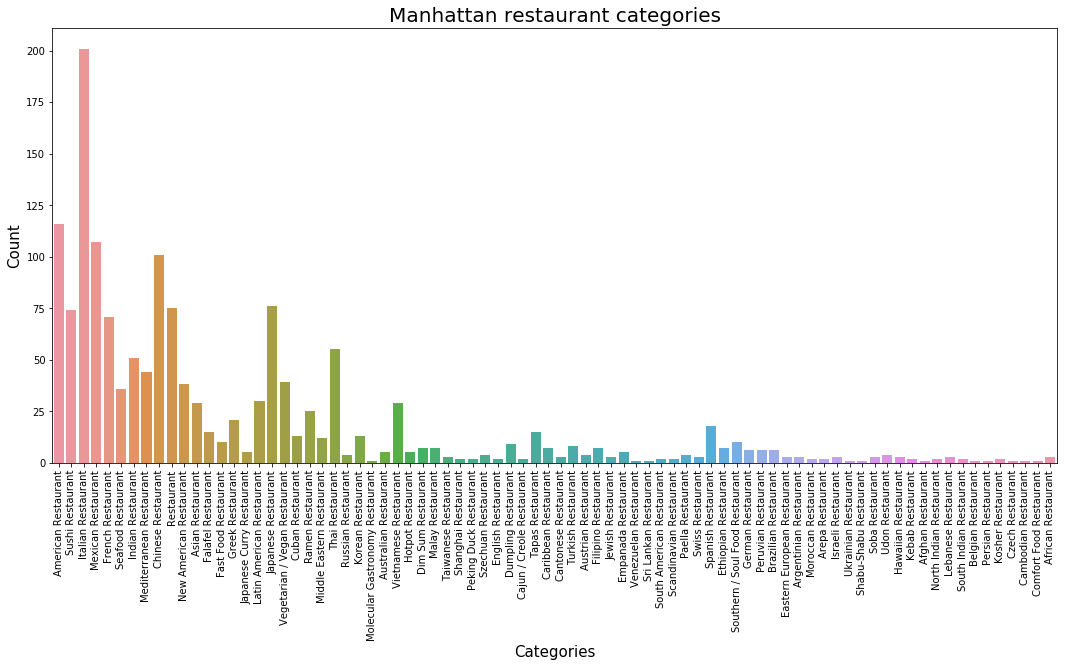

In [30]:
# Install and import plotting libraries
try:
    import seaborn as sns
except:
    !conda install -c conda-forge seaborn --yes
    import seaborn as sns

import matplotlib.pyplot as plt

# Plot restaurant categories
fig = plt.figure(figsize=(18, 8))
sns.countplot(manhattan_restaurants["Categories"])
plt.title("Manhattan restaurant categories", fontsize=20)
plt.xticks(rotation=90)
plt.xlabel("Categories", fontsize=15)
plt.ylabel("Count", fontsize=15)

We see that there are about 200 Italian restaurants in Manhattan. Let's filter the dataset by categories and leave only Italian Restaurants.

In [31]:
italian_restaurants = manhattan_restaurants[manhattan_restaurants["Categories"] == "Italian Restaurant"].reset_index(drop=True)
italian_restaurants.head()

Address          Categories  \
0  250 Vesey St (West St),New York, NY 10080,Unit...  Italian Restaurant   
1  101 Liberty St (at Greenwich St),New York, NY ...  Italian Restaurant   
2     235 S End Ave,New York, NY 10280,United States  Italian Restaurant   
3  2 Gold St (at Maiden Ln.),New York, NY 10038,U...  Italian Restaurant   
4         5 Gold St,New York, NY 10038,United States  Italian Restaurant   

   DistanceToNeighbourhood   Latitude  Longitude       Neighbourhood  \
0                      393  40.714514 -74.016264   Battery Park City   
1                      376  40.710554 -74.012519   Battery Park City   
2                      146  40.709731 -74.016588   Battery Park City   
3                      201  40.707634 -74.006996  Financial District   
4                      179  40.707548 -74.007249  Financial District   

                       Venue                  Venue_id  
0                       Parm  556cb8c6498e751e51fbcf41  
1         Osteria della Pace  57b4d7d7498e0b675b71f653  
2                 Benevenuti  4f204819e4b05266c3c2c51c  
3  Harry's Italian Pizza Bar  4a4560a7f964a5201aa81fe3  
4             Giardino D'oro  4bb54fe02f70c9b6c6188430

Let's plot the Italian restaurants on a map.

In [32]:
# Get the coordinates for Manhattan
manhattan_address = "Manhattan, New York"

geolocator = Nominatim(user_agent="my_app")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
location = geocode(manhattan_address)
latitude = location.latitude
longitude = location.longitude
print("The geograpical coordinates of Manhattan are {}, {}.".format(latitude, longitude))

The geograpical coordinates of Manhattan are 40.7900869, -73.9598295.


In [33]:
# Create map of Manhattan using latitude and longitude values
italian_restaurants_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to map
cols = zip(
    italian_restaurants["Latitude"],
    italian_restaurants["Longitude"],
    italian_restaurants["Venue"]
)

for lat, lng, label in cols:
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color="blue",
        fill=True,
        fill_color="#3186cc",
        fill_opacity=0.7
    ).add_to(italian_restaurants_map)  
    
italian_restaurants_map

If we look at the map above, we see that most of the Italian restaurants are located in the lower half of Manhattan.

We will now get the details for each restaurant using the venue detail endpoint of the Foursquare API.

In [35]:
def get_venue_details(venue_ids):
    details_data = []
    
    for venue_id in venue_ids:
        url = "https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}".format(
            venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        
        # Make a GET request
        response = requests.get(url).json()

        detail_obj = response["response"]["venue"]
        timings = []
        if detail_obj.get("popular", None) is not None and detail_obj["popular"].get("timeframes", None) is not None:
            timings_obj = detail_obj["popular"]["timeframes"]
            for to in timings_obj:
                if to["days"] != "Today":
                    for t in to['open']:
                        timings.append({ to["days"]: t["renderedTime"] })

        attributes_obj = detail_obj["attributes"]["groups"]
        attrs = []
        for ao in attributes_obj:
            if ao["name"] != "Price":
                for a in ao["items"]:
                    attrs.append({ a["displayName"]: a["displayValue"]})

        data_obj = {
            "Venue_id": venue_id,
            "Venue": detail_obj["name"],
            "Verified": detail_obj.get("verified", None),
            "Dislike": detail_obj.get("dislike", None),
            "OK": detail_obj.get("ok", None),
            "Rating": detail_obj.get("rating", None),
            "Rating Signals": detail_obj.get("ratingSignals", None),
            "Timings": timings,
            "Attributes": attrs
        }
        
        if detail_obj.get("price", None) is not None:
            data_obj["Price Tier"] = detail_obj["price"]["tier"]
            data_obj["Price Message"] = detail_obj["price"]["message"]
        
        if detail_obj.get("likes", None) is not None:
            data_obj["Likes"] = detail_obj["likes"]["count"]
        
        if detail_obj.get("reasons", None) is not None:
            data_obj["Review Summary"] = detail_obj["reasons"]["items"]
        
        if detail_obj.get("tips", None) is not None:
            data_obj["Tips"] = detail_obj["tips"]["count"]
        
        if detail_obj.get("specials", None) is not None:
            data_obj["Specials"] = detail_obj["specials"]["items"]
        
        if detail_obj.get("listed", None) is not None:
            data_obj["On Lists"] = detail_obj["listed"]["count"]
        
        details_data.append(data_obj)
    
    # Create a dataframe
    restaurant_details = pd.DataFrame(details_data)
    
    return restaurant_details

In [36]:
# Fetch ratings, timings, pricing, review summary
restaurant_details_final = get_venue_details(get_data_ids)
restaurant_details_final.head()

Attributes  Dislike  Likes     OK  \
0  [{'Credit Cards': 'Yes (incl. Discover & Visa)...    False    239  False   
1         [{'Lunch': 'Lunch'}, {'Dinner': 'Dinner'}]    False     41  False   
2  [{'Brunch': 'Brunch'}, {'Lunch': 'Lunch'}, {'D...    False     19  False   
3  [{'Reservations': 'No'}, {'Outdoor Seating': '...    False      2  False   
4                                                 []    False      1  False   

   On Lists Price Message  Price Tier  Rating  Rating Signals  \
0       172      Moderate           2     8.5           335.0   
1        18      Moderate           2     7.9            51.0   
2         2      Moderate           2     7.9            22.0   
3         0      Moderate           2     NaN             NaN   
4         0      Moderate           2     NaN             NaN   

                                      Review Summary Specials  \
0  [{'summary': 'Lots of people like this place',...       []   
1  [{'summary': 'Lots of people like this place',...       []   
2                                                 []       []   
3                                                 []       []   
4                                                 []       []   

                                             Timings  Tips  \
0  [{'Sun': '1:00 PM–9:00 PM'}, {'Mon': 'Noon–2:0...    67   
1  [{'Sun': '11:00 AM–9:00 PM'}, {'Mon': 'Noon–2:...     3   
2  [{'Mon': '1:00 PM–3:00 PM'}, {'Mon': '5:00 PM–...     1   
3                                                 []     2   
4                                                 []     1   

                Venue                  Venue_id  Verified  
0                Parm  556cb8c6498e751e51fbcf41      True  
1  Osteria della Pace  57b4d7d7498e0b675b71f653     False  
2        Vino e Grano  59792b2403369334be043a56     False  
3          Benevenuti  4f204819e4b05266c3c2c51c     False  
4           250 Vesey  53ce695d498eafe0168816e6     False

In [37]:
manhattan_final = pd.merge(italian_restaurants, restaurant_details_final, on="Venue_id")
print("Final dataframe shape: {} x {}".format(manhattan_final.shape[0], manhattan_final.shape[1]))
manhattan_final = manhattan_final.drop("Venue_y", axis=1).rename(columns={"Venue_x": "Venue"})
manhattan_final.head()

Final dataframe shape: 201 x 23


Address          Categories  \
0  250 Vesey St (West St),New York, NY 10080,Unit...  Italian Restaurant   
1  101 Liberty St (at Greenwich St),New York, NY ...  Italian Restaurant   
2     235 S End Ave,New York, NY 10280,United States  Italian Restaurant   
3  2 Gold St (at Maiden Ln.),New York, NY 10038,U...  Italian Restaurant   
4         5 Gold St,New York, NY 10038,United States  Italian Restaurant   

   DistanceToNeighbourhood   Latitude  Longitude       Neighbourhood  \
0                      393  40.714514 -74.016264   Battery Park City   
1                      376  40.710554 -74.012519   Battery Park City   
2                      146  40.709731 -74.016588   Battery Park City   
3                      201  40.707634 -74.006996  Financial District   
4                      179  40.707548 -74.007249  Financial District   

                       Venue                  Venue_id  \
0                       Parm  556cb8c6498e751e51fbcf41   
1         Osteria della Pace  57b4d7d7498e0b675b71f653   
2                 Benevenuti  4f204819e4b05266c3c2c51c   
3  Harry's Italian Pizza Bar  4a4560a7f964a5201aa81fe3   
4             Giardino D'oro  4bb54fe02f70c9b6c6188430   

                                          Attributes  Dislike  Likes     OK  \
0  [{'Credit Cards': 'Yes (incl. Discover & Visa)...    False    239  False   
1         [{'Lunch': 'Lunch'}, {'Dinner': 'Dinner'}]    False     41  False   
2  [{'Reservations': 'No'}, {'Outdoor Seating': '...    False      2  False   
3  [{'Credit Cards': 'Yes (incl. American Express...    False    305  False   
4  [{'Credit Cards': 'Yes'}, {'Outdoor Seating': ...    False     33  False   

   On Lists   Price Message  Price Tier  Rating  Rating Signals  \
0       172        Moderate           2     8.5           335.0   
1        18        Moderate           2     7.9            51.0   
2         0        Moderate           2     NaN             NaN   
3       251       Expensive           3     8.3           503.0   
4        13  Very Expensive           4     8.2            52.0   

                                      Review Summary Specials  \
0  [{'summary': 'Lots of people like this place',...       []   
1  [{'summary': 'Lots of people like this place',...       []   
2                                                 []       []   
3  [{'summary': 'Lots of people like this place',...       []   
4  [{'summary': 'Lots of people like this place',...       []   

                                             Timings  Tips  Verified  
0  [{'Sun': '1:00 PM–9:00 PM'}, {'Mon': 'Noon–2:0...    67      True  
1  [{'Sun': '11:00 AM–9:00 PM'}, {'Mon': 'Noon–2:...     3     False  
2                                                 []     2     False  
3  [{'Mon': 'Noon–2:00 PM'}, {'Mon': '6:00 PM–9:0...   140      True  
4  [{'Mon–Tue': 'Noon–3:00 PM'}, {'Mon–Tue': '5:0...    17     False

Some of the rows have no Ratings and Rating Signals. We will exclude these.

In [38]:
manhattan_final = manhattan_final.dropna(subset=["Rating"], how="all", axis=0)
manhattan_final = manhattan_final.reset_index(drop=True)
manhattan_final.head()

Address          Categories  \
0  250 Vesey St (West St),New York, NY 10080,Unit...  Italian Restaurant   
1  101 Liberty St (at Greenwich St),New York, NY ...  Italian Restaurant   
2  2 Gold St (at Maiden Ln.),New York, NY 10038,U...  Italian Restaurant   
3         5 Gold St,New York, NY 10038,United States  Italian Restaurant   
4        15 Gold St,New York, NY 10038,United States  Italian Restaurant   

   DistanceToNeighbourhood   Latitude  Longitude       Neighbourhood  \
0                      393  40.714514 -74.016264   Battery Park City   
1                      376  40.710554 -74.012519   Battery Park City   
2                      201  40.707634 -74.006996  Financial District   
3                      179  40.707548 -74.007249  Financial District   
4                      198  40.707832 -74.007040  Financial District   

                       Venue                  Venue_id  \
0                       Parm  556cb8c6498e751e51fbcf41   
1         Osteria della Pace  57b4d7d7498e0b675b71f653   
2  Harry's Italian Pizza Bar  4a4560a7f964a5201aa81fe3   
3             Giardino D'oro  4bb54fe02f70c9b6c6188430   
4      Felice 15 Gold Street  5078413372da7d9d2e0d54ca   

                                          Attributes  Dislike  Likes     OK  \
0  [{'Credit Cards': 'Yes (incl. Discover & Visa)...    False    239  False   
1         [{'Lunch': 'Lunch'}, {'Dinner': 'Dinner'}]    False     41  False   
2  [{'Credit Cards': 'Yes (incl. American Express...    False    305  False   
3  [{'Credit Cards': 'Yes'}, {'Outdoor Seating': ...    False     33  False   
4  [{'Credit Cards': 'Yes (incl. Discover & Visa)...    False    140  False   

   On Lists   Price Message  Price Tier  Rating  Rating Signals  \
0       172        Moderate           2     8.5           335.0   
1        18        Moderate           2     7.9            51.0   
2       251       Expensive           3     8.3           503.0   
3        13  Very Expensive           4     8.2            52.0   
4       131  Very Expensive           4     8.2           217.0   

                                      Review Summary Specials  \
0  [{'summary': 'Lots of people like this place',...       []   
1  [{'summary': 'Lots of people like this place',...       []   
2  [{'summary': 'Lots of people like this place',...       []   
3  [{'summary': 'Lots of people like this place',...       []   
4  [{'summary': 'Lots of people like this place',...       []   

                                             Timings  Tips  Verified  
0  [{'Sun': '1:00 PM–9:00 PM'}, {'Mon': 'Noon–2:0...    67      True  
1  [{'Sun': '11:00 AM–9:00 PM'}, {'Mon': 'Noon–2:...     3     False  
2  [{'Mon': 'Noon–2:00 PM'}, {'Mon': '6:00 PM–9:0...   140      True  
3  [{'Mon–Tue': 'Noon–3:00 PM'}, {'Mon–Tue': '5:0...    17     False  
4  [{'Mon': '5:00 PM–9:00 PM'}, {'Tue': 'Noon–1:0...    50      True

In [39]:
import json
import numpy as np

def convert_str_to_list(str_value):
    str_value = str_value.replace("\'", "\"")
    list_value = json.loads(str_value)
    return list_value

In [40]:
# Convert string values to lists
manhattan_final["Review Summary"] = manhattan_final["Review Summary"].apply(convert_str_to_list)
manhattan_final["Attributes"] = manhattan_final["Attributes"].apply(convert_str_to_list)
manhattan_final["Timings"] = manhattan_final["Timings"].apply(convert_str_to_list)

In [41]:
# Fix the review summary column
manhattan_final["Review Summary"].tolist()
manhattan_final["Review Summary"] = manhattan_final["Review Summary"].apply(lambda r: r[0]["summary"] if len(r) > 0 else "")

In [42]:
# Fix the attribute column
attribute_details = []
for row in range(0, manhattan_final.shape[0]):
    temp = {}
    temp["Venue_id"] = manhattan_final.loc[row, "Venue_id"]
    
    for row_attr in manhattan_final.loc[row, "Attributes"]:
        temp[list(row_attr.keys())[0]] = list(row_attr.values())[0]
    attribute_details.append(temp)

# Create a dataframe
venue_attributes_df = pd.DataFrame(attribute_details)

venue_attributes_df.head()

ATM  BYO Bar Service Bar Snacks  Beer  Breakfast  Brunch Coat Check  \
0  NaN  NaN         NaN        NaN  Beer        NaN  Brunch        NaN   
1  NaN  NaN         NaN        NaN   NaN        NaN     NaN        NaN   
2  NaN  NaN         NaN        NaN  Beer        NaN  Brunch        NaN   
3  NaN  NaN         NaN        NaN   NaN        NaN     NaN        NaN   
4  NaN  NaN         NaN        NaN   NaN  Breakfast  Brunch        NaN   

   Cocktails                  Credit Cards     Delivery  Dessert  Dinner  \
0  Cocktails   Yes (incl. Discover & Visa)     Delivery  Dessert  Dinner   
1        NaN                           NaN          NaN      NaN  Dinner   
2  Cocktails  Yes (incl. American Express)     Delivery      NaN  Dinner   
3  Cocktails                           Yes  No Delivery      NaN  Dinner   
4  Cocktails   Yes (incl. Discover & Visa)     Delivery      NaN  Dinner   

   Full Bar Groups Only  Happy Hour Jukebox Live Music  Lunch Music  \
0  Full Bar         NaN  Happy Hour     NaN        NaN  Lunch   NaN   
1       NaN         NaN         NaN     NaN        NaN  Lunch   NaN   
2  Full Bar         NaN  Happy Hour     NaN        NaN  Lunch   NaN   
3  Full Bar         NaN         NaN     NaN        NaN  Lunch   NaN   
4  Full Bar         NaN  Happy Hour     NaN        NaN  Lunch   NaN   

  Outdoor Seating Parking Private Lot Private Room Reservations Restroom  \
0              No     NaN         NaN          NaN          NaN      NaN   
1             NaN     NaN         NaN          NaN          NaN      NaN   
2             Yes     NaN         NaN          NaN          NaN      NaN   
3              No     NaN         NaN          NaN          NaN      NaN   
4              No     NaN         NaN          NaN          NaN      NaN   

  Street Parking  TVs Table Service Take-out Tasting Menu Valet Parking  \
0         Street  Yes           NaN      NaN          NaN           NaN   
1            NaN  NaN           NaN      NaN          NaN           NaN   
2            NaN  NaN           NaN      NaN          NaN           NaN   
3            NaN  NaN           NaN      NaN          NaN           NaN   
4            NaN  NaN           NaN      NaN          NaN           NaN   

                   Venue_id Wheelchair Accessible Wi-Fi  Wine  
0  556cb8c6498e751e51fbcf41                   NaN  Free  Wine  
1  57b4d7d7498e0b675b71f653                   NaN   NaN   NaN  
2  4a4560a7f964a5201aa81fe3                   NaN   Yes  Wine  
3  4bb54fe02f70c9b6c6188430                   NaN   NaN  Wine  
4  5078413372da7d9d2e0d54ca                   NaN   NaN  Wine

We can see that many of the attributes have no values. Let's get the count for each attribute.

In [43]:
venue_attributes_df.describe(include="all")

ATM  BYO  Bar Service  Bar Snacks  Beer  Breakfast  Brunch Coat Check  \
count     2    5            5           2    31         24      99          7   
unique    1    1            1           1     1          1       1          1   
top     Yes  BYO  Bar Service  Bar Snacks  Beer  Breakfast  Brunch        Yes   
freq      2    5            5           2    31         24      99          7   

        Cocktails                 Credit Cards  Delivery  Dessert  Dinner  \
count         125                          170       176       22     181   
unique          1                            9         2        1       1   
top     Cocktails  Yes (incl. Discover & Visa)  Delivery  Dessert  Dinner   
freq          125                           71       118       22     181   

        Full Bar  Groups Only  Happy Hour  Jukebox  Live Music  Lunch Music  \
count        121            1          57        1           8    127    17   
unique         1            1           1        1           1      1     2   
top     Full Bar  Groups Only  Happy Hour  Jukebox  Live Music  Lunch    No   
freq         121            1          57        1           8    127     9   

       Outdoor Seating Parking  Private Lot Private Room Reservations  \
count              170       2            1            4           64   
unique               2       1            1            1            2   
top                 No     Yes  Private Lot          Yes          Yes   
freq                91       2            1            4           43   

       Restroom Street Parking  TVs  Table Service  Take-out  Tasting Menu  \
count        37             29    3              9        11             4   
unique        1              1    1              1         1             1   
top         Yes         Street  Yes  Table Service  Take-out  Tasting Menu   
freq         37             29    3              9        11             4   

       Valet Parking                  Venue_id Wheelchair Accessible Wi-Fi  \
count              1                       194                    24    47   
unique             1                       194                     1     3   
top            Valet  54459a46498ecf8ec204cc61                   Yes   Yes   
freq               1                         1                    24    21   

        Wine  
count    124  
unique     1  
top     Wine  
freq     124

Let's keep the attributes with more than 10 frequency values and drop the rest.

In [44]:
attr_counts = venue_attributes_df.count().to_dict()
attrs_to_drop = [key for key in attr_counts.keys() if attr_counts[key] < 11]
print(list(attrs_to_drop))

['ATM', 'BYO', 'Bar Service', 'Bar Snacks', 'Coat Check', 'Groups Only', 'Jukebox', 'Live Music', 'Parking', 'Private Lot', 'Private Room', 'TVs', 'Table Service', 'Tasting Menu', 'Valet Parking']


In [45]:
venue_attributes_df = venue_attributes_df.drop(attrs_to_drop, axis=1).reset_index(drop=True)
venue_attributes_df.head()

Beer  Breakfast  Brunch  Cocktails                  Credit Cards  \
0  Beer        NaN  Brunch  Cocktails   Yes (incl. Discover & Visa)   
1   NaN        NaN     NaN        NaN                           NaN   
2  Beer        NaN  Brunch  Cocktails  Yes (incl. American Express)   
3   NaN        NaN     NaN  Cocktails                           Yes   
4   NaN  Breakfast  Brunch  Cocktails   Yes (incl. Discover & Visa)   

      Delivery  Dessert  Dinner  Full Bar  Happy Hour  Lunch Music  \
0     Delivery  Dessert  Dinner  Full Bar  Happy Hour  Lunch   NaN   
1          NaN      NaN  Dinner       NaN         NaN  Lunch   NaN   
2     Delivery      NaN  Dinner  Full Bar  Happy Hour  Lunch   NaN   
3  No Delivery      NaN  Dinner  Full Bar         NaN  Lunch   NaN   
4     Delivery      NaN  Dinner  Full Bar  Happy Hour  Lunch   NaN   

  Outdoor Seating Reservations Restroom Street Parking Take-out  \
0              No          NaN      NaN         Street      NaN   
1             NaN          NaN      NaN            NaN      NaN   
2             Yes          NaN      NaN            NaN      NaN   
3              No          NaN      NaN            NaN      NaN   
4              No          NaN      NaN            NaN      NaN   

                   Venue_id Wheelchair Accessible Wi-Fi  Wine  
0  556cb8c6498e751e51fbcf41                   NaN  Free  Wine  
1  57b4d7d7498e0b675b71f653                   NaN   NaN   NaN  
2  4a4560a7f964a5201aa81fe3                   NaN   Yes  Wine  
3  4bb54fe02f70c9b6c6188430                   NaN   NaN  Wine  
4  5078413372da7d9d2e0d54ca                   NaN   NaN  Wine

In [46]:
# Fill missing values with 0 (No)
venue_attributes_df = venue_attributes_df.fillna(0)

# Convert other values to 1 (Yes) or 0 (No)
venue_attributes_df = venue_attributes_df.replace(["Yes", "No"], [1, 0])
columns = venue_attributes_df.columns.tolist()
venue_attributes_df = venue_attributes_df.replace(columns, [1 for n in range(len(columns))])
venue_attributes_df = venue_attributes_df.replace(["No Delivery", "Street", "Free", "Valet"], [0, 1, 1, 1])
credit_indices = venue_attributes_df[~venue_attributes_df["Credit Cards"].isin([1, 0])]["Credit Cards"].index
venue_attributes_df.loc[credit_indices, "Credit Cards"] = 1

venue_attributes_df.head()

Beer  Breakfast  Brunch  Cocktails  Credit Cards  Delivery  Dessert  \
0     1          0       1          1             1         1        1   
1     0          0       0          0             0         0        0   
2     1          0       1          1             1         1        0   
3     0          0       0          1             1         0        0   
4     0          1       1          1             1         1        0   

   Dinner  Full Bar  Happy Hour  Lunch  Music  Outdoor Seating  Reservations  \
0       1         1           1      1      0                0             0   
1       1         0           0      1      0                0             0   
2       1         1           1      1      0                1             0   
3       1         1           0      1      0                0             0   
4       1         1           1      1      0                0             0   

   Restroom  Street Parking  Take-out                  Venue_id  \
0         0               1         0  556cb8c6498e751e51fbcf41   
1         0               0         0  57b4d7d7498e0b675b71f653   
2         0               0         0  4a4560a7f964a5201aa81fe3   
3         0               0         0  4bb54fe02f70c9b6c6188430   
4         0               0         0  5078413372da7d9d2e0d54ca   

   Wheelchair Accessible  Wi-Fi  Wine  
0                      0      1     1  
1                      0      0     0  
2                      0      1     1  
3                      0      0     1  
4                      0      0     1

In [47]:
# Merge the restaurant data with venue details
manhattan_final_attrs = pd.merge(manhattan_final, venue_attributes_df, on="Venue_id")

# Replace boolean values to binary
manhattan_final_attrs = manhattan_final_attrs.replace([True, False], [1, 0])

# Drop the original attributes column
manhattan_final_attrs = manhattan_final_attrs.drop("Attributes", axis=1)

manhattan_final_attrs.head()

Address          Categories  \
0  250 Vesey St (West St),New York, NY 10080,Unit...  Italian Restaurant   
1  101 Liberty St (at Greenwich St),New York, NY ...  Italian Restaurant   
2  2 Gold St (at Maiden Ln.),New York, NY 10038,U...  Italian Restaurant   
3         5 Gold St,New York, NY 10038,United States  Italian Restaurant   
4        15 Gold St,New York, NY 10038,United States  Italian Restaurant   

   DistanceToNeighbourhood   Latitude  Longitude       Neighbourhood  \
0                      393  40.714514 -74.016264   Battery Park City   
1                      376  40.710554 -74.012519   Battery Park City   
2                      201  40.707634 -74.006996  Financial District   
3                      179  40.707548 -74.007249  Financial District   
4                      198  40.707832 -74.007040  Financial District   

                       Venue                  Venue_id  Dislike  Likes  OK  \
0                       Parm  556cb8c6498e751e51fbcf41        0    239   0   
1         Osteria della Pace  57b4d7d7498e0b675b71f653        0     41   0   
2  Harry's Italian Pizza Bar  4a4560a7f964a5201aa81fe3        0    305   0   
3             Giardino D'oro  4bb54fe02f70c9b6c6188430        0     33   0   
4      Felice 15 Gold Street  5078413372da7d9d2e0d54ca        0    140   0   

   On Lists   Price Message  Price Tier  Rating  Rating Signals  \
0       172        Moderate           2     8.5           335.0   
1        18        Moderate           2     7.9            51.0   
2       251       Expensive           3     8.3           503.0   
3        13  Very Expensive           4     8.2            52.0   
4       131  Very Expensive           4     8.2           217.0   

                   Review Summary Specials  \
0  Lots of people like this place       []   
1  Lots of people like this place       []   
2  Lots of people like this place       []   
3  Lots of people like this place       []   
4  Lots of people like this place       []   

                                             Timings  Tips  Verified  Beer  \
0  [{'Sun': '1:00 PM–9:00 PM'}, {'Mon': 'Noon–2:0...    67         1     1   
1  [{'Sun': '11:00 AM–9:00 PM'}, {'Mon': 'Noon–2:...     3         0     0   
2  [{'Mon': 'Noon–2:00 PM'}, {'Mon': '6:00 PM–9:0...   140         1     1   
3  [{'Mon–Tue': 'Noon–3:00 PM'}, {'Mon–Tue': '5:0...    17         0     0   
4  [{'Mon': '5:00 PM–9:00 PM'}, {'Tue': 'Noon–1:0...    50         1     0   

   Breakfast  Brunch  Cocktails  Credit Cards  Delivery  Dessert  Dinner  \
0          0       1          1             1         1        1       1   
1          0       0          0             0         0        0       1   
2          0       1          1             1         1        0       1   
3          0       0          1             1         0        0       1   
4          1       1          1             1         1        0       1   

   Full Bar  Happy Hour  Lunch  Music  Outdoor Seating  Reservations  \
0         1           1      1      0                0             0   
1         0           0      1      0                0             0   
2         1           1      1      0                1             0   
3         1           0      1      0                0             0   
4         1           1      1      0                0             0   

   Restroom  Street Parking  Take-out  Wheelchair Accessible  Wi-Fi  Wine  
0         0               1         0                      0      1     1  
1         0               0         0                      0      0     0  
2         0               0         0                      0      1     1  
3         0               0         0                      0      0     1  
4         0               0         0                      0      0     1

In [48]:
# Fix the timings column
timings_list = []

for row in range(0, manhattan_final_attrs.shape[0]):
    temp = {}
    temp["Venue_id"] = manhattan_final_attrs.loc[row, "Venue_id"]
    
    for row_attr in manhattan_final_attrs.loc[row, "Timings"]:
        temp[list(row_attr.keys())[0]] = list(row_attr.values())[0]
    timings_list.append(temp)

timings_df = pd.DataFrame(timings_list)
timings_df.head()

Fri Fri–Sat Fri–Sun               Mon           Mon–Tue  \
0  5:00 PM–11:00 PM     NaN     NaN   6:00 PM–9:00 PM               NaN   
1  5:00 PM–11:00 PM     NaN     NaN  5:00 PM–10:00 PM               NaN   
2  5:00 PM–Midnight     NaN     NaN   6:00 PM–9:00 PM               NaN   
3  5:00 PM–10:00 PM     NaN     NaN               NaN  5:00 PM–10:00 PM   
4  5:00 PM–11:00 PM     NaN     NaN   5:00 PM–9:00 PM               NaN   

  Mon–Wed               Sat Sat–Sun               Sun               Thu  \
0     NaN               NaN     NaN   1:00 PM–9:00 PM  5:00 PM–10:00 PM   
1     NaN               NaN     NaN  11:00 AM–9:00 PM  6:00 PM–10:00 PM   
2     NaN  6:00 PM–Midnight     NaN               NaN  5:00 PM–11:00 PM   
3     NaN  5:00 PM–10:00 PM     NaN               NaN  5:00 PM–10:00 PM   
4     NaN  4:00 PM–11:00 PM     NaN               NaN               NaN   

  Thu–Fri Thu–Sat               Tue Tue–Fri Tue–Thu           Tue–Wed  \
0     NaN     NaN               NaN     NaN     NaN   5:00 PM–9:00 PM   
1     NaN     NaN   6:00 PM–9:00 PM     NaN     NaN               NaN   
2     NaN     NaN               NaN     NaN     NaN  5:00 PM–10:00 PM   
3     NaN     NaN               NaN     NaN     NaN               NaN   
4     NaN     NaN  5:00 PM–10:00 PM     NaN     NaN               NaN   

                   Venue_id               Wed Wed–Fri           Wed–Thu  
0  556cb8c6498e751e51fbcf41               NaN     NaN               NaN  
1  57b4d7d7498e0b675b71f653   4:00 PM–9:00 PM     NaN               NaN  
2  4a4560a7f964a5201aa81fe3               NaN     NaN               NaN  
3  4bb54fe02f70c9b6c6188430  5:00 PM–10:00 PM     NaN               NaN  
4  5078413372da7d9d2e0d54ca               NaN     NaN  5:00 PM–10:00 PM

We can see that timings are missing for many restaurants. So we will ignore the timings column.

In [49]:
manhattan_final_attrs = manhattan_final_attrs.drop("Timings", axis=1)

Let's check the Dislike, OK and Specials columns.

In [50]:
print("Dislike values other than 0: {}".format(len(manhattan_final_attrs[manhattan_final_attrs["Dislike"] != 0])))
print("OK values other than 0: {}".format(len(manhattan_final_attrs[manhattan_final_attrs["OK"] != 0])))
print("Specials values other than '[]': {}".format(len(manhattan_final_attrs[manhattan_final_attrs["Specials"] != "[]"])))
print("Review Summary unique values:")
print(manhattan_final_attrs["Review Summary"].unique().tolist())

Dislike values other than 0: 0
OK values other than 0: 0
Specials values other than '[]': 0
Review Summary unique values:
['Lots of people like this place', '']


Only 1 row has a value for the specials column. The Dislike and OK columns have 0s for all rows. The Review Summary column has only 1 value which doesn't provide helpful information. So let's drop all 4. Since all the rows are Italian restaurants, we will drop the Categories column too.

In [51]:
manhattan_final_attrs = manhattan_final_attrs.drop(["Specials", "Dislike", "OK", "Review Summary", "Categories"], axis=1)
manhattan_final_attrs.head()

Address  DistanceToNeighbourhood  \
0  250 Vesey St (West St),New York, NY 10080,Unit...                      393   
1  101 Liberty St (at Greenwich St),New York, NY ...                      376   
2  2 Gold St (at Maiden Ln.),New York, NY 10038,U...                      201   
3         5 Gold St,New York, NY 10038,United States                      179   
4        15 Gold St,New York, NY 10038,United States                      198   

    Latitude  Longitude       Neighbourhood                      Venue  \
0  40.714514 -74.016264   Battery Park City                       Parm   
1  40.710554 -74.012519   Battery Park City         Osteria della Pace   
2  40.707634 -74.006996  Financial District  Harry's Italian Pizza Bar   
3  40.707548 -74.007249  Financial District             Giardino D'oro   
4  40.707832 -74.007040  Financial District      Felice 15 Gold Street   

                   Venue_id  Likes  On Lists   Price Message  Price Tier  \
0  556cb8c6498e751e51fbcf41    239       172        Moderate           2   
1  57b4d7d7498e0b675b71f653     41        18        Moderate           2   
2  4a4560a7f964a5201aa81fe3    305       251       Expensive           3   
3  4bb54fe02f70c9b6c6188430     33        13  Very Expensive           4   
4  5078413372da7d9d2e0d54ca    140       131  Very Expensive           4   

   Rating  Rating Signals  Tips  Verified  Beer  Breakfast  Brunch  Cocktails  \
0     8.5           335.0    67         1     1          0       1          1   
1     7.9            51.0     3         0     0          0       0          0   
2     8.3           503.0   140         1     1          0       1          1   
3     8.2            52.0    17         0     0          0       0          1   
4     8.2           217.0    50         1     0          1       1          1   

   Credit Cards  Delivery  Dessert  Dinner  Full Bar  Happy Hour  Lunch  \
0             1         1        1       1         1           1      1   
1             0         0        0       1         0           0      1   
2             1         1        0       1         1           1      1   
3             1         0        0       1         1           0      1   
4             1         1        0       1         1           1      1   

   Music  Outdoor Seating  Reservations  Restroom  Street Parking  Take-out  \
0      0                0             0         0               1         0   
1      0                0             0         0               0         0   
2      0                1             0         0               0         0   
3      0                0             0         0               0         0   
4      0                0             0         0               0         0   

   Wheelchair Accessible  Wi-Fi  Wine  
0                      0      1     1  
1                      0      0     0  
2                      0      1     1  
3                      0      0     1  
4                      0      0     1

Let's check how many restaurants in our list do not provide lunch and dinner.

In [52]:
manhattan_final_attrs[["Venue_id", "Lunch", "Dinner"]].groupby(["Lunch", "Dinner"]).count()

Venue_id
Lunch Dinner          
0     0              8
      1             59
1     0              5
      1            122

There are 8 restaurants providing neither lunch nor dinner. We will drop these rows.

In [53]:
no_lh_dn = manhattan_final_attrs[(manhattan_final_attrs["Lunch"] == 0) & (manhattan_final_attrs["Dinner"] == 0)].index
manhattan_final_attrs = manhattan_final_attrs.drop(no_lh_dn, axis=0).reset_index(drop=True)
manhattan_final_attrs.shape

(186, 35)

### 1.4. Fetch venues near each restaurant  

Let's use the search endpoint of the Foursquare API to get a list of places around each restaurant within a radius of 250 meters.

In [55]:
def get_searches(venue_ids, venues, latitudes, longitudes, limit, radius):
    details = []
    
    print("Searching for places around ...")
    
    for venue_id, venue_name, lat, lon in zip(venue_ids, venues, latitudes, longitudes):
        print(venue_name)
        url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&intent=browse".format(
            CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, radius, limit)

        # Make a GET request
        response = requests.get(url).json()
        
        for venue in response["response"]["venues"]:
            # Ignore if same as venue_id
            if venue["id"] != venue_id:
                # Get the categories of search results around a restaurant
                categories = venue["categories"]
                for cat in categories:
                    if cat["name"] != "" and cat["primary"] == True:
                        details.append({
                            "Venue_id": venue_id,
                            "Categories": cat["name"],
                            "Distance": venue["location"]["distance"]
                        })
    
    # Create a dataframe
    search_result_df = pd.DataFrame(details)
    
    return search_result_df

In [56]:
search_result_df = get_searches(manhattan_final_attrs["Venue_id"], manhattan_final_attrs["Venue"],
                                manhattan_final_attrs["Latitude"], manhattan_final_attrs["Longitude"],
                                100, 250)

Searching for places around ...
Parm
Osteria della Pace
Harry's Italian Pizza Bar
Giardino D'oro
Felice 15 Gold Street
Vino e Grano
Da Claudio
Cipriani
Scalini Fedeli
Gran Morsi
Max
Sole di Capri
Gigino Trattoria
Tutto Il Giorno Tribeca
Tre Sorelle
Sapori Ditalia
Babbo Ristorante e Enoteca
Il Cantinori
Il Mulino New York
Arte
Aunt Jake's
Casa Apicii
Olio e Piú
Gene's
Palma
Gelso & Grand
Paesano of Mulberry Street
La Mela
Il Cortile
Benito One
Pepe Rosso Social
Puglia Restaurant
Forlini's
Da Nico Ristorante
Speedy Romeo LES
Noga
Il Buco
Il Buco Alimentari & Vineria
Emilio's Ballato
Vic's
Bar Primi
Gemma
Piccola Strada
Misirizzi
Osteria Morini
Sant Ambroeus SoHo
Rubirosa Ristorante
Parm
Galli Restaurant
Emporio
Cipriani Downtown
Peasant
Aurora
San Carlo Osteria Piemonte
Coco Pazzo Kitchen & Restaurant
L'Artusi
I Sodi
Sant Ambroeus West Village
Extra Virgin
Frankies Spuntino 570
Via Carota
Morandi
The Meatball Shop
Malaparte
Piccolo Angolo
Don Angie
Rosemary’s
Barbuto
Suprema Provisions
M

In [57]:
print("Rows: {} Columns: {}".format(search_result_df.shape[0], search_result_df.shape[1]))
search_result_df.head()

Rows: 17404 Columns: 3


Categories  Distance                  Venue_id
0                Park       150  556cb8c6498e751e51fbcf41
1        Tech Startup       119  556cb8c6498e751e51fbcf41
2        Neighborhood        48  556cb8c6498e751e51fbcf41
3  Mexican Restaurant        94  556cb8c6498e751e51fbcf41
4         Bus Station        30  556cb8c6498e751e51fbcf41

In [58]:
# Drop venues more than 250 metres away
search_categories = search_result_df[search_result_df["Distance"] <= 250]

print("Rows: {} Columns: {}".format(search_categories.shape[0], search_categories.shape[1]))

search_categories.head()

Rows: 17124 Columns: 3


Categories  Distance                  Venue_id
0                Park       150  556cb8c6498e751e51fbcf41
1        Tech Startup       119  556cb8c6498e751e51fbcf41
2        Neighborhood        48  556cb8c6498e751e51fbcf41
3  Mexican Restaurant        94  556cb8c6498e751e51fbcf41
4         Bus Station        30  556cb8c6498e751e51fbcf41

In [59]:
# Transform the nearest categories for a venue into columns

def transform_rows_to_cols(df, total_cols):
    search_category_cols = []
    for i in range(0, total_cols):
        search_category_cols.append("Neighbour - " + str(i))
    
    venue_ids = df["Venue_id"].unique().tolist()
    
    transformed_df = pd.DataFrame()
    
    for vid in venue_ids:
        temp_df = df[df["Venue_id"] == vid]
        temp_df = temp_df.sort_values("Distance")[0:total_cols]
        temp_df = temp_df[["Categories"]].T
        temp_df = temp_df.reset_index(drop=True)
        temp_df.columns = search_category_cols
        temp_df["Venue_id"] = vid
        transformed_df = pd.concat([transformed_df, temp_df], axis=0)
        
    return transformed_df

In [60]:
search_categories_df = transform_rows_to_cols(search_categories.copy(), 10)
search_categories_df.head()

Neighbour - 0                             Neighbour - 1  \
0       Boat or Ferry                                    Office   
0         Pizza Place                                 Gift Shop   
0  Italian Restaurant                                    Bakery   
0  Italian Restaurant                            Hardware Store   
0  Italian Restaurant  Residential Building (Apartment / Condo)   

        Neighbour - 2                             Neighbour - 3  \
0       Burrito Place                               Bus Station   
0          Restaurant                                  Wine Bar   
0            Wine Bar                               Candy Store   
0  Physical Therapist  Residential Building (Apartment / Condo)   
0              Lounge                               Snack Place   

        Neighbour - 4               Neighbour - 5    Neighbour - 6  \
0              Office                 Coffee Shop  Doctor's Office   
0  Italian Restaurant  Financial or Legal Service           Office   
0        Gourmet Shop                Dessert Shop       Beer Store   
0              Lounge                      School          Parking   
0      Mattress Store              Hardware Store          Parking   

        Neighbour - 7        Neighbour - 8       Neighbour - 9  \
0        Neighborhood               Office            Bus Line   
0         Coffee Shop         Tech Startup      Chocolate Shop   
0         Coffee Shop       Ice Cream Shop  Mexican Restaurant   
0             Parking  American Restaurant                 Gym   
0  Italian Restaurant      Laundry Service            Building   

                   Venue_id  
0  556cb8c6498e751e51fbcf41  
0  57b4d7d7498e0b675b71f653  
0  4a4560a7f964a5201aa81fe3  
0  4bb54fe02f70c9b6c6188430  
0  5078413372da7d9d2e0d54ca

Let's merge the search categories and the Italian restaurant details dataframes.

In [61]:
manhattan_italian_restaurants = pd.merge(manhattan_final_attrs, search_categories_df, on="Venue_id")
print(manhattan_italian_restaurants.shape)
manhattan_italian_restaurants.head()

(186, 45)


Address  DistanceToNeighbourhood  \
0  250 Vesey St (West St),New York, NY 10080,Unit...                      393   
1  101 Liberty St (at Greenwich St),New York, NY ...                      376   
2  2 Gold St (at Maiden Ln.),New York, NY 10038,U...                      201   
3         5 Gold St,New York, NY 10038,United States                      179   
4        15 Gold St,New York, NY 10038,United States                      198   

    Latitude  Longitude       Neighbourhood                      Venue  \
0  40.714514 -74.016264   Battery Park City                       Parm   
1  40.710554 -74.012519   Battery Park City         Osteria della Pace   
2  40.707634 -74.006996  Financial District  Harry's Italian Pizza Bar   
3  40.707548 -74.007249  Financial District             Giardino D'oro   
4  40.707832 -74.007040  Financial District      Felice 15 Gold Street   

                   Venue_id  Likes  On Lists   Price Message  Price Tier  \
0  556cb8c6498e751e51fbcf41    239       172        Moderate           2   
1  57b4d7d7498e0b675b71f653     41        18        Moderate           2   
2  4a4560a7f964a5201aa81fe3    305       251       Expensive           3   
3  4bb54fe02f70c9b6c6188430     33        13  Very Expensive           4   
4  5078413372da7d9d2e0d54ca    140       131  Very Expensive           4   

   Rating  Rating Signals  Tips  Verified  Beer  Breakfast  Brunch  Cocktails  \
0     8.5           335.0    67         1     1          0       1          1   
1     7.9            51.0     3         0     0          0       0          0   
2     8.3           503.0   140         1     1          0       1          1   
3     8.2            52.0    17         0     0          0       0          1   
4     8.2           217.0    50         1     0          1       1          1   

   Credit Cards  Delivery  Dessert  Dinner  Full Bar  Happy Hour  Lunch  \
0             1         1        1       1         1           1      1   
1             0         0        0       1         0           0      1   
2             1         1        0       1         1           1      1   
3             1         0        0       1         1           0      1   
4             1         1        0       1         1           1      1   

   Music  Outdoor Seating  Reservations  Restroom  Street Parking  Take-out  \
0      0                0             0         0               1         0   
1      0                0             0         0               0         0   
2      0                1             0         0               0         0   
3      0                0             0         0               0         0   
4      0                0             0         0               0         0   

   Wheelchair Accessible  Wi-Fi  Wine       Neighbour - 0  \
0                      0      1     1       Boat or Ferry   
1                      0      0     0         Pizza Place   
2                      0      1     1  Italian Restaurant   
3                      0      0     1  Italian Restaurant   
4                      0      0     1  Italian Restaurant   

                              Neighbour - 1       Neighbour - 2  \
0                                    Office       Burrito Place   
1                                 Gift Shop          Restaurant   
2                                    Bakery            Wine Bar   
3                            Hardware Store  Physical Therapist   
4  Residential Building (Apartment / Condo)              Lounge   

                              Neighbour - 3       Neighbour - 4  \
0                               Bus Station              Office   
1                                  Wine Bar  Italian Restaurant   
2                               Candy Store        Gourmet Shop   
3  Residential Building (Apartment / Condo)              Lounge   
4                               Snack Place      Mattress Store   

                Neighbour - 5    Neighbour - 6       Neighbour - 7  \


## 2. Modeling

### 2.1. Feature selection

Now that we have the details of each restaurant, we can begin segmenting them. We will use a clustering algorithm to do this.

We will use the AgglomerativeClustering implementation from the scikit-learn python library. AgglomerativeClustering is a hierarchical clustering algorithm that follows a bottom-up approach, starting with each data point as a cluster and merging clusters as it moves up the hierarchy.

We will chose likes, on lists, price tier, rating, rating signals, and tips for clustering.

We will drop the remaining columns and add them back after clustering.

In [62]:
# Select features for clustering
included_cols = ["Likes", "On Lists", "Price Tier", "Rating", "Rating Signals", "Tips"]
restaurants_analysis = manhattan_italian_restaurants[included_cols]

restaurants_analysis.head()

Likes  On Lists  Price Tier  Rating  Rating Signals  Tips
0    239       172           2     8.5           335.0    67
1     41        18           2     7.9            51.0     3
2    305       251           3     8.3           503.0   140
3     33        13           4     8.2            52.0    17
4    140       131           4     8.2           217.0    50

### 2.2. Feature Normalization
We will need to standarize the values in the dataset. Values for rating signals are more than 1000 while those for each of the attributes are between 0 - 1.

Since clustering algorithms are sensitive to the magnitudes of values while computing distances between data points, the columns with high values can bias the clustering. We will use the MinMaxScaler which scales each feature within a range of 0 to 1.

In [63]:
# Install and import scikit-learn
try:
    from sklearn.preprocessing import MinMaxScaler
except:
    !conda install -c scikit-learn --yes
    from sklearn.preprocessing import MinMaxScaler

from scipy.cluster import hierarchy
from scipy.spatial import distance_matrix
from sklearn.cluster import AgglomerativeClustering

In [64]:
X = restaurants_analysis.values[:,1:]
X = np.nan_to_num(X)
manhattan_norm = MinMaxScaler().fit_transform(X)
manhattan_norm[0:5]

array([[0.03016485, 0.33333333, 0.72222222, 0.10562016, 0.08545918],
       [0.00315679, 0.33333333, 0.55555556, 0.01388889, 0.00382653],
       [0.04401964, 0.66666667, 0.66666667, 0.15988372, 0.17857143],
       [0.0022799 , 1.        , 0.63888889, 0.01421189, 0.02168367],
       [0.02297439, 1.        , 0.63888889, 0.06750646, 0.06377551]])

### 2.3. Clustering  
Let's create a dendogram to visualize hierarchical clustering.

In [65]:
# Create a distance matrix
dist_matrix = distance_matrix(manhattan_norm, manhattan_norm) 
print(dist_matrix)

[[0.         0.20877195 0.3549703  ... 0.35998843 0.32993938 0.18658138]
 [0.20877195 0.         0.42068615 ... 0.16705647 0.13917406 0.05093037]
 [0.3549703  0.42068615 0.         ... 0.4961689  0.47528849 0.39657432]
 ...
 [0.35998843 0.16705647 0.4961689  ... 0.         0.03033662 0.17654532]
 [0.32993938 0.13917406 0.47528849 ... 0.03033662 0.         0.14633184]
 [0.18658138 0.05093037 0.39657432 ... 0.17654532 0.14633184 0.        ]]


/home/karen/Documents/Work/Projects/Study/MachineLearning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


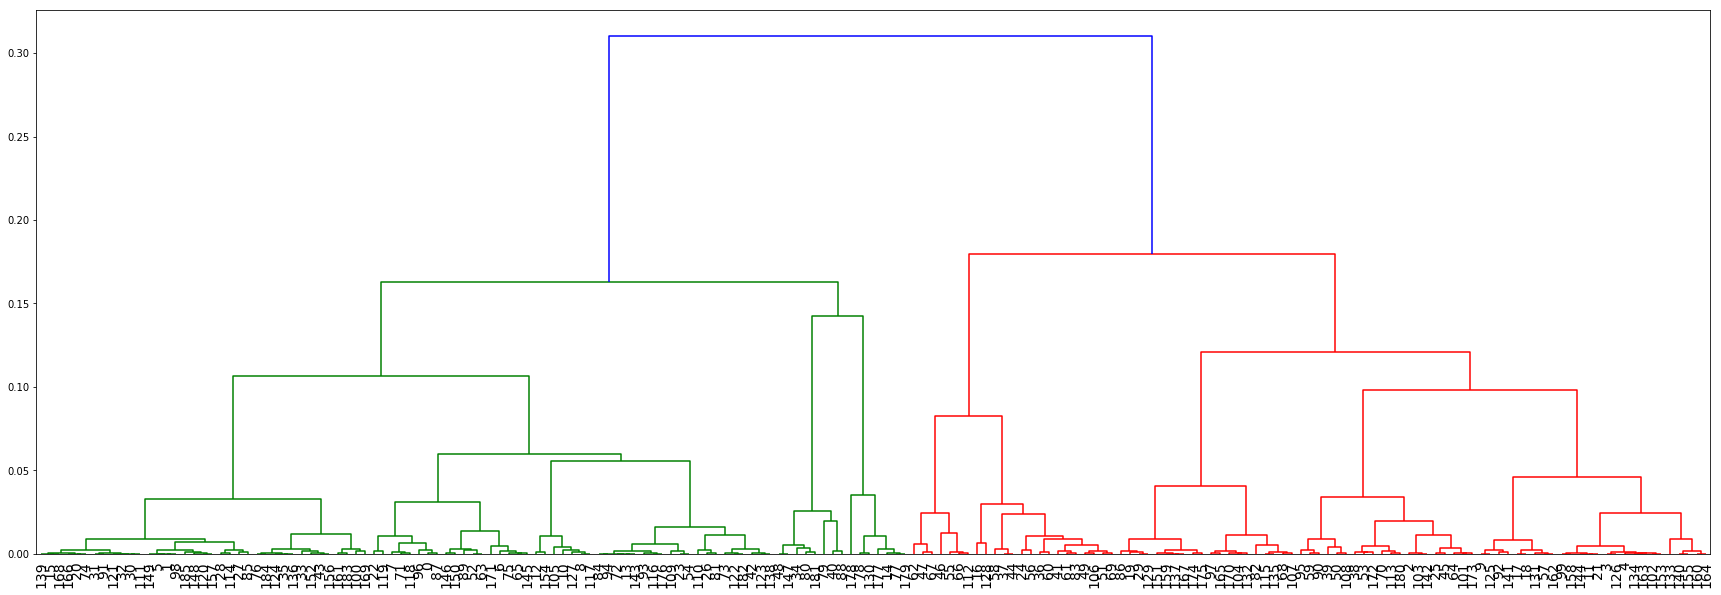

In [66]:
dendro_fig = plt.figure(figsize=(30, 10))
Z = hierarchy.linkage(dist_matrix, method="complete", metric="cosine")
dendrogram = hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=14)

The above dendrogram has 2 clusters. Let's choose the clusters below 0.25 on the y-axis and create a model with 4 clusters.

In [67]:
num_clusters = 4
agglom = AgglomerativeClustering(n_clusters=num_clusters, linkage="complete", affinity="cosine")
agglom.fit(manhattan_norm)
labels = agglom.labels_
labels[0:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 3, 0])

In [68]:
# Get the original columns which were dropped
manhattan_clustered = manhattan_italian_restaurants.copy()

# Add cluster labels
manhattan_clustered['Cluster Labels'] = labels

manhattan_clustered.head()

Address  DistanceToNeighbourhood  \
0  250 Vesey St (West St),New York, NY 10080,Unit...                      393   
1  101 Liberty St (at Greenwich St),New York, NY ...                      376   
2  2 Gold St (at Maiden Ln.),New York, NY 10038,U...                      201   
3         5 Gold St,New York, NY 10038,United States                      179   
4        15 Gold St,New York, NY 10038,United States                      198   

    Latitude  Longitude       Neighbourhood                      Venue  \
0  40.714514 -74.016264   Battery Park City                       Parm   
1  40.710554 -74.012519   Battery Park City         Osteria della Pace   
2  40.707634 -74.006996  Financial District  Harry's Italian Pizza Bar   
3  40.707548 -74.007249  Financial District             Giardino D'oro   
4  40.707832 -74.007040  Financial District      Felice 15 Gold Street   

                   Venue_id  Likes  On Lists   Price Message  Price Tier  \
0  556cb8c6498e751e51fbcf41    239       172        Moderate           2   
1  57b4d7d7498e0b675b71f653     41        18        Moderate           2   
2  4a4560a7f964a5201aa81fe3    305       251       Expensive           3   
3  4bb54fe02f70c9b6c6188430     33        13  Very Expensive           4   
4  5078413372da7d9d2e0d54ca    140       131  Very Expensive           4   

   Rating  Rating Signals  Tips  Verified  Beer  Breakfast  Brunch  Cocktails  \
0     8.5           335.0    67         1     1          0       1          1   
1     7.9            51.0     3         0     0          0       0          0   
2     8.3           503.0   140         1     1          0       1          1   
3     8.2            52.0    17         0     0          0       0          1   
4     8.2           217.0    50         1     0          1       1          1   

   Credit Cards  Delivery  Dessert  Dinner  Full Bar  Happy Hour  Lunch  \
0             1         1        1       1         1           1      1   
1             0         0        0       1         0           0      1   
2             1         1        0       1         1           1      1   
3             1         0        0       1         1           0      1   
4             1         1        0       1         1           1      1   

   Music  Outdoor Seating  Reservations  Restroom  Street Parking  Take-out  \
0      0                0             0         0               1         0   
1      0                0             0         0               0         0   
2      0                1             0         0               0         0   
3      0                0             0         0               0         0   
4      0                0             0         0               0         0   

   Wheelchair Accessible  Wi-Fi  Wine       Neighbour - 0  \
0                      0      1     1       Boat or Ferry   
1                      0      0     0         Pizza Place   
2                      0      1     1  Italian Restaurant   
3                      0      0     1  Italian Restaurant   
4                      0      0     1  Italian Restaurant   

                              Neighbour - 1       Neighbour - 2  \
0                                    Office       Burrito Place   
1                                 Gift Shop          Restaurant   
2                                    Bakery            Wine Bar   
3                            Hardware Store  Physical Therapist   
4  Residential Building (Apartment / Condo)              Lounge   

                              Neighbour - 3       Neighbour - 4  \
0                               Bus Station              Office   
1                                  Wine Bar  Italian Restaurant   
2                               Candy Store        Gourmet Shop   
3  Residential Building (Apartment / Condo)              Lounge   
4                               Snack Place      Mattress Store   

                Neighbour - 5    Neighbour - 6       Neighbour - 7  \


## 3. Results   
Let's visualize the clusters on a map.

In [69]:
import matplotlib.colors as colors
from matplotlib.pyplot import cm

# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i+x+(i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
marker_cols = zip(manhattan_clustered['Latitude'], manhattan_clustered['Longitude'],
                  manhattan_clustered['Venue'], manhattan_clustered['Rating'], manhattan_clustered['Cluster Labels'])

for lat, lon, venue, rating, cluster in marker_cols:
    label = folium.Popup(str(venue) + '(' + str(rating) + ')' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's look at the restaurants in each cluster.

In [70]:
# Skip latitude and longitude columns
cluster_cols = manhattan_clustered.columns[[0, 1] + list(range(4, manhattan_clustered.shape[1]))]

In [71]:
cluster0 = manhattan_clustered.loc[manhattan_clustered['Cluster Labels'] == 0, cluster_cols]
cluster0

Address  \
3           5 Gold St,New York, NY 10038,United States   
4          15 Gold St,New York, NY 10038,United States   
9    22 Warren St (Church St),New York, NY 10007,Un...   
11   165 Church St (at Reade St),New York, NY 10007...   
14   61 Reade St (Broadway),New York, NY 10007,Unit...   
19   21 E 9th St (University Place & 5th Ave),New Y...   
21        62 W 9th St,New York, NY 10011,United States   
29    174 Mulberry St,New York, NY 10013,United States   
77   174 Avenue B (11th Street),New York, NY 10009,...   
78   E 4th St (Ave B),New York, NY 10009,United States   
86   182 2nd Ave (btwn E 11th & E 12th St),New York...   
92   88 Ninth Avenue (btwn W 16th & W 17th St),New ...   
99   325 W 51st St (8th & 9th Aves.),New York, NY 1...   
102  54 W 55th St (btwn 5th & 6th),New York, NY 100...   
125  107 E 34th St (btwn Park & Lexington),New York...   
126     108 E 38th St,New York, NY 10016,United States   
129  184 Lexington Ave (btw 31st & 32nd),New York, ...   
130       343 2nd Ave,New York, NY 10003,United States   
133  244 E 46th St (btw 2nd and 3rd Ave),New York, ...   
134  231 E 50th St (btwn 2nd & 3rd Ave),New York, N...   
137  337 E 49th St (btw 2nd ave and 1st ave),New Yo...   
140  214 E 52nd St (Between 2nd and 3rd Ave),New Yo...   
141  142 W 65th St (Lincoln Center),New York, NY 10...   
144  11 W 60th St (at Broadway),New York, NY 10023,...   
151  412 Amsterdam Ave (btwn W 79th & 80th Sts),New...   
153  1382 1st Ave (at E 74th St.),New York, NY 1002...   
155  1354 1st Ave (btwn 72nd & 73rd St),New York, N...   
158  967 Lexington Ave (at E 70th St.),New York, NY...   
159  1226 2nd Ave (btw 64th St and 65th St),New Yor...   
160  969 Lexington Ave,New York, NY 10021,United St...   
163   903 Madison Ave,New York, NY 10021,United States   
164  23 E 74th St (Madison Ave),New York, NY 10021,...   
167  140 E 74th St (Lexington),New York, NY 10021,U...   
174  347 E 85th St (btw 1st & 2nd),New York, NY 100...   
175  1748 1st Ave (at E 91st St.),New York, NY 1012...   
177  345 E 83rd St (at 1st Ave),New York, NY 10028,...   
178  1617 York Ave (at E. 85th St.),New York, NY 10...   
179  1580 3rd Ave (88th St & 89th Sts),New York, NY...   

     DistanceToNeighbourhood         Neighbourhood  \
3                        179    Financial District   
4                        198    Financial District   
9                        171               TriBeCa   
11                       136               TriBeCa   
14                       241               TriBeCa   
19                       160     Greenwich Village   
21                       274     Greenwich Village   
29                       134          Little Italy   
77                       263         Alphabet City   
78                       328         Alphabet City   
86                       192          East Village   
92                       488               Chelsea   
99                       487               Clinton   
102                      202               Midtown   
125                      213           Murray Hill   
126                      102           Murray Hill   
129                      419           Murray Hill   
130                      465  Peter Cooper Village   
133                      452            Tudor City   
134                      220            Turtle Bay   
137                      108            Turtle Bay   
140                      355            Turtle Bay   
141                      226        Lincoln Square   
144                      469        Lincoln Square   
151                      441       Upper West Side   
153                      419            Lenox Hill   
155                      344            Lenox Hill   
158                      462            Lenox Hill   
159                      371            Lenox Hill   
160                      462            Lenox Hill   
163                      207       Upper East Side   
164                       70       Upper East Side   
16

In [72]:
cluster0.describe()

DistanceToNeighbourhood       Likes    On Lists  Price Tier     Rating  \
count                38.000000   38.000000   38.000000   38.000000  38.000000   
mean                295.526316   46.421053   68.815789    3.394737   7.573684   
std                 128.906364   49.506009  118.583043    0.754786   0.714969   
min                  70.000000    6.000000    1.000000    2.000000   5.900000   
25%                 199.000000   21.250000   15.000000    3.000000   7.400000   
50%                 268.500000   27.500000   26.500000    4.000000   7.700000   
75%                 419.000000   55.000000   52.500000    4.000000   8.175000   
max                 488.000000  261.000000  592.000000    4.000000   8.600000   

       Rating Signals       Tips   Verified       Beer  Breakfast     Brunch  \
count       38.000000  38.000000  38.000000  38.000000  38.000000  38.000000   
mean        75.894737  22.500000   0.368421   0.026316   0.157895   0.342105   
std         73.703126  18.062579   0.488852   0.162221   0.369537   0.480783   
min         12.000000   4.000000   0.000000   0.000000   0.000000   0.000000   
25%         39.250000  12.250000   0.000000   0.000000   0.000000   0.000000   
50%         47.500000  18.000000   0.000000   0.000000   0.000000   0.000000   
75%         83.750000  26.250000   1.000000   0.000000   0.000000   1.000000   
max        380.000000  95.000000   1.000000   1.000000   1.000000   1.000000   

       Cocktails  Credit Cards   Delivery    Dessert  Dinner   Full Bar  \
count  38.000000     38.000000  38.000000  38.000000    38.0  38.000000   
mean    0.552632      0.868421   0.552632   0.105263     1.0   0.578947   
std     0.503897      0.342570   0.503897   0.311012     0.0   0.500355   
min     0.000000      0.000000   0.000000   0.000000     1.0   0.000000   
25%     0.000000      1.000000   0.000000   0.000000     1.0   0.000000   
50%     1.000000      1.000000   1.000000   0.000000     1.0   1.000000   
75%     1.000000      1.000000   1.000000   0.000000     1.0   1.000000   
max     1.000000      1.000000   1.000000   1.000000     1.0   1.000000   

       Happy Hour      Lunch  Music  Outdoor Seating  Reservations   Restroom  \
count   38.000000  38.000000   38.0        38.000000     38.000000  38.000000   
mean     0.105263   0.526316    0.0         0.263158      0.210526   0.105263   
std      0.311012   0.506009    0.0         0.446258      0.413155   0.311012   
min      0.000000   0.000000    0.0         0.000000      0.000000   0.000000   
25%      0.000000   0.000000    0.0         0.000000      0.000000   0.000000   
50%      0.000000   1.000000    0.0         0.000000      0.000000   0.000000   
75%      0.000000   1.000000    0.0         0.750000      0.000000   0.000000   
max      1.000000   1.000000    0.0         1.000000      1.000000   1.000000   

       Street Parking  Take-out  Wheelchair Accessible      Wi-Fi       Wine  \
count       38.000000      38.0              38.000000  38.000000  38.000000   
mean         0.078947       0.0               0.078947   0.131579   0.447368   
std          0.273276       0.0               0.273276   0.342570   0.503897   
min          0.000000       0.0               0.000000   0.000000   0.000000   
25%          0.000000       0.0               0.000000   0.000000   0.000000   
50%          0.000000       0.0               0.000000   0.000000   0.000000   
75%          0.000000       0.0               0.000000   0.000000   1.000000   
max          1.000000       0.0               1.000000   1.000000   1.000000   

       Cluster Labels  
count            38.0  
mean              0.0  
std               0.0  
min               0.0  
25%               0.0  
50%               0.0  
75%               0.0  
max               0.0

In [73]:
cluster1 = manhattan_clustered.loc[manhattan_clustered['Cluster Labels'] == 1, cluster_cols]
cluster1

Address  \
0    250 Vesey St (West St),New York, NY 10080,Unit...   
1    101 Liberty St (at Greenwich St),New York, NY ...   
2    2 Gold St (at Maiden Ln.),New York, NY 10038,U...   
5    4 World Trade Ctr,New York, NY 10007,United St...   
6    21 Ann St (btwn Theatre Aly & Park Row),New Yo...   
7         25 Broadway,New York, NY 10004,United States   
13   114 Franklin St (West Broadway),New York, NY 1...   
15                          New York, NY,United States   
16   110 Waverly Pl (btwn MacDougal Alley & 6th Ave...   
17   32 E 10th St (btwn Broadway & University),New ...   
18   86 W 3rd St (btwn Sullivan & Thompson St),New ...   
20   47 W 8th St (McDougal),New York, NY 10011,Unit...   
22   3 Greenwich Ave (at 6th Ave),New York, NY 1001...   
23   73 W 11th St (btwn 5th & 6th Ave),New York, NY...   
24   28 Cornelia St (btwn Bleecker St & W 4th St),N...   
25   186 Grand St (btwn Baxter St & Centre Market P...   
26   136 Mulberry St (btwn Hester & Grand),New York...   
27   167 Mulberry St (btw Broome St. & Grand St.),N...   
28   125 Mulberry St (btwn Canal & Hester),New York...   
30   173 Mott St (at Broome St),New York, NY 10013,...   
31   189 Hester St (btwn Mott And Mulberry),New Yor...   
32   98 Baxter St. (btwn Bayad & Walker),New York, ...   
33   164 Mulberry St (btwn Broome & Grand St.),New ...   
34      63 Clinton St,New York, NY 10002,United States   
35       120 Allen St,New York, NY 10002,United States   
36   47 Bond St (btwn Lafayette & Bowery),New York,...   
37   53 Great Jones St (btwn Lafayette St & Bowery)...   
38   55 E Houston St (at Mott St),New York, NY 1001...   
39   31 Great Jones St,New York, NY 10012,United St...   
41   335 Bowery (btwn E 2nd & E 3rd St),New York, N...   
42   77 E 4th St (btw Bowery & 2nd Ave),New York, N...   
43   36 E 4th St (Bowery),New York, NY 10003,United...   
44   218 Lafayette St (btwn Kenmare & Spring St),Ne...   
45   265 Lafayette St (at Prince St),New York, NY 1...   
48   45 Mercer St (Broome & Grand Streets),New York...   
49   231 Mott St (btwn Prince & Spring St),New York...   
50   376 W Broadway (btwn Spring & Broome),New York...   
51   194 Elizabeth St (btwn Prince & Spring St),New...   
52   510 Broome St (btw W Broadway & Thompson),New ...   
53   90 Thompson St (Spring St),New York, NY 10012,...   
54      160 Prince St,New York, NY 10012,United States   
56   105 Christopher St (at Bleecker St),New York, ...   
57   259 W 4th St (Perry St.),New York, NY 10014,Un...   
58   259 W 4th St (btw Charles & Perry St),New York...   
59   570 Hudson St (at W 11th St),New York, NY 1001...   
60        51 Grove St,New York, NY 10014,United States   
61   211 Waverly Pl (at 7th Ave),New York, NY 10014...   
63   753 Washington St (at Bethune St),New York, NY...   
64   621 Hudson St (at Jane St),New York, NY 10014,...   
65   103 Greenwich Ave,New York, NY 10014,United St...   
68   305 Bleecker St (at 7th Ave S),New York, NY 10...   
69   649 Washington St (btwn 10th St & Christopher ...   
70   545 E 5th St (btw Ave A & Ave B),New York, NY ...   
71   337 E 10th St (Avenue B),New York, NY 10009,Un...   
72   647 E 11th (Ave C),New York, NY 10009,United S...   
73   126 E 7th St (Avenue A),New York, NY 10009,Uni...   
74       234 E 4th St,New York, NY 10009,United States   
75   190 E 2nd St (at Avenue B),New York, NY 10009,...   
76   130 Saint Marks Pl,New York, NY 10009,United S...   
80   88 2nd Ave (at E 5th St),New York, NY 10003,Un...   
81   48 E 7th St (btwn 1st & 2nd Ave),New York, NY ...   
82   21 E 7th St (btwn 2nd & 3rd Ave),New York, NY ...   
83   403 E 12th St (at 1st Ave),New York, NY 10009,...   
84   309 E 5th St (btwn 1st Ave & 2nd Ave),New York...   
85   302 E 12th St (btwn 1st & 2nd Ave),New York, N...   
87   136 Division St (at Ludlow St.),New York, NY 1...   
89   195 10th Ave (btw 21st and 22nd),New York, NY ...   
90   232 8th Ave (btwn W 21st & W 22nd St),New York...   
91   246 10th Ave (at W 24th St),New York, NY

In [74]:
cluster1.describe()

DistanceToNeighbourhood       Likes     On Lists  Price Tier  \
count               131.000000  131.000000   131.000000  131.000000   
mean                308.244275  188.236641   354.061069    2.442748   
std                 119.116820  177.281256   453.706509    0.596919   
min                  48.000000    5.000000     0.000000    2.000000   
25%                 207.000000   62.000000    74.500000    2.000000   
50%                 321.000000  117.000000   163.000000    2.000000   
75%                 404.000000  272.500000   492.500000    3.000000   
max                 498.000000  755.000000  2065.000000    4.000000   

           Rating  Rating Signals        Tips    Verified        Beer  \
count  131.000000      131.000000  131.000000  131.000000  131.000000   
mean     8.358015      275.503817   70.496183    0.580153    0.160305   
std      0.548979      249.326273   63.863481    0.495428    0.368297   
min      7.100000        8.000000    0.000000    0.000000    0.000000   
25%      7.900000      105.500000   19.500000    0.000000    0.000000   
50%      8.300000      179.000000   51.000000    1.000000    0.000000   
75%      8.800000      393.000000  101.000000    1.000000    0.000000   
max      9.400000     1027.000000  282.000000    1.000000    1.000000   

        Breakfast      Brunch   Cocktails  Credit Cards    Delivery  \
count  131.000000  131.000000  131.000000    131.000000  131.000000   
mean     0.106870    0.572519    0.709924      0.809160    0.618321   
std      0.310134    0.496612    0.455539      0.394471    0.487663   
min      0.000000    0.000000    0.000000      0.000000    0.000000   
25%      0.000000    0.000000    0.000000      1.000000    0.000000   
50%      0.000000    1.000000    1.000000      1.000000    1.000000   
75%      0.000000    1.000000    1.000000      1.000000    1.000000   
max      1.000000    1.000000    1.000000      1.000000    1.000000   

          Dessert      Dinner    Full Bar  Happy Hour       Lunch       Music  \
count  131.000000  131.000000  131.000000  131.000000  131.000000  131.000000   
mean     0.099237    0.984733    0.671756    0.343511    0.694656    0.045802   
std      0.300127    0.123084    0.471377    0.476703    0.462321    0.209857   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    1.000000    1.000000    0.000000    1.000000    0.000000   
75%      0.000000    1.000000    1.000000    1.000000    1.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

       Outdoor Seating  Reservations    Restroom  Street Parking    Take-out  \
count       131.000000    131.000000  131.000000      131.000000  131.000000   
mean          0.465649      0.236641    0.190840        0.145038    0.045802   
std           0.500733      0.426652    0.394471        0.353491    0.209857   
min           0.000000      0.000000    0.000000        0.000000    0.000000   
25%           0.000000      0.000000    0.000000        0.000000    0.000000   
50%           0.000000      0.000000    0.000000        0.000000    0.000000   
75%           1.000000      0.000000    0.000000        0.000000    0.000000   
max           1.000000      1.000000    1.000000        1.000000    1.000000   

       Wheelchair Accessible       Wi-Fi        Wine  Cluster Labels  
count             131.000000  131.000000  131.000000           131.0  
mean                0.122137    0.190840    0.709924             1.0  
std                 0.328701    0.394471    0.455539             0.0  
min                 0.000000    0.000000    0.000000             1.0  
25%                 0.000000    0.000000    0.000000             1.0  
50%                 0.000000    0.000000    1.000000             1.0  
75%                 0.000000    0.000000    1.000000             1.0  
max                 1.000000    1.000000    1.0000

In [75]:
cluster2 = manhattan_clustered.loc[manhattan_clustered['Cluster Labels'] == 2, cluster_cols]
cluster2

Address  \
40   325 Bowery (at E 2nd St),New York, NY 10003,Un...   
46   235 Mulberry St (btwn Prince & Spring St),New ...   
47   248 Mulberry St (btwn Prince & Spring St),New ...   
55   228 W 10th St (btwn Bleecker & Hudson St),New ...   
62   64 Greenwich Ave (at Perry St),New York, NY 10...   
66   18 Greenwich Ave (at W 10th St),New York, NY 1...   
67   775 Washington St (btwn Jane St & 12th St),New...   
88   200 9th Ave (btwn W 22nd St & W 23rd St),New Y...   
112  2 Lexington Ave (at Gramercy Park N),New York,...   

     DistanceToNeighbourhood  Neighbourhood                Venue  \
40                       186           NoHo            Bar Primi   
46                       236           SoHo  Rubirosa Ristorante   
47                       251           SoHo                 Parm   
55                       156   West Village             L'Artusi   
62                       331   West Village    The Meatball Shop   
66                       403   West Village           Rosemary’s   
67                       405   West Village              Barbuto   
88                        55        Chelsea    The Meatball Shop   
112                       63  Gramercy Park             Maialino   

                     Venue_id  Likes  On Lists Price Message  Price Tier  \
40   53726183498e6a101ea7fd06    598      1323      Moderate           2   
46   4cc6222106c25481d7a4a047   2364      5702      Moderate           2   
47   4d9f8d97a428a1cdd92acb04   1111      2210      Moderate           2   
55   4a27289cf964a52062911fe3   1088      3303     Expensive           3   
62   4eb5e354b8f786e2756cb884   1066      1544      Moderate           2   
66   4fccfed41081ba9a64ce9613   1419      3401     Expensive           3   
67   42225f00f964a520b21f1fe3    964      2713      Moderate           2   
88   511d6006e4b0a486ec088c89    993       897      Moderate           2   
112  4afb2990f964a520a91b22e3   1406      3435     Expensive           3   

     Rating  Rating Signals  Tips  Verified  Beer  Breakfast  Brunch  \
40      8.9           833.0   189         0     0          0       1   
46      9.5          3104.0   784         1     1          0       1   
47      9.1          1584.0   487         1     1          0       1   
55      9.5          1420.0   352         1     0          0       0   
62      9.2          1362.0   274         1     1          0       1   
66      9.3          1836.0   360         1     1          1       1   
67      9.1          1326.0   332         1     1          0       1   
88      9.0          1279.0   185         1     1          0       0   
112     9.3          1894.0   463         1     1          1       1   

     Cocktails  Credit Cards  Delivery  Dessert  Dinner  Full Bar  Happy Hour  \
40           1             1         1        1       1         1           1   
46           1             1         0        0       1         1           0   
47           1             1         1        1       1         1           0   
55           1             1         0        0       1         1           0   
62           1             1         1        0       1         1           1   
66           1             1         1        1       1         0           0   
67           1             1         1        0       1         1           1   
88           1             1         0        0       1         1           1   
112          1             1         0        1       1         1           1   

     Lunch  Music  Outdoor Seating  Reservations  Restroom  Street Parking  \
40       1      0                1             0         0               0   
46       1      0                0             1         1               1   
47       1      0                0             0         0               0   
55       0      0                0             0         0               0   
62       1      0                1             0         0               0   
66       1      1       

In [76]:
cluster2.describe()

DistanceToNeighbourhood        Likes     On Lists  Price Tier  \
count                 9.000000     9.000000     9.000000    9.000000   
mean                231.777778  1223.222222  2725.333333    2.333333   
std                 130.924384   492.418719  1463.087745    0.500000   
min                  55.000000   598.000000   897.000000    2.000000   
25%                 156.000000   993.000000  1544.000000    2.000000   
50%                 236.000000  1088.000000  2713.000000    2.000000   
75%                 331.000000  1406.000000  3401.000000    3.000000   
max                 405.000000  2364.000000  5702.000000    3.000000   

         Rating  Rating Signals        Tips  Verified      Beer  Breakfast  \
count  9.000000        9.000000    9.000000  9.000000  9.000000   9.000000   
mean   9.211111     1626.444444  380.666667  0.888889  0.777778   0.222222   
std    0.208833      637.726452  183.976901  0.333333  0.440959   0.440959   
min    8.900000      833.000000  185.000000  0.000000  0.000000   0.000000   
25%    9.100000     1326.000000  274.000000  1.000000  1.000000   0.000000   
50%    9.200000     1420.000000  352.000000  1.000000  1.000000   0.000000   
75%    9.300000     1836.000000  463.000000  1.000000  1.000000   0.000000   
max    9.500000     3104.000000  784.000000  1.000000  1.000000   1.000000   

         Brunch  Cocktails  Credit Cards  Delivery   Dessert  Dinner  \
count  9.000000        9.0           9.0  9.000000  9.000000     9.0   
mean   0.777778        1.0           1.0  0.555556  0.444444     1.0   
std    0.440959        0.0           0.0  0.527046  0.527046     0.0   
min    0.000000        1.0           1.0  0.000000  0.000000     1.0   
25%    1.000000        1.0           1.0  0.000000  0.000000     1.0   
50%    1.000000        1.0           1.0  1.000000  0.000000     1.0   
75%    1.000000        1.0           1.0  1.000000  1.000000     1.0   
max    1.000000        1.0           1.0  1.000000  1.000000     1.0   

       Full Bar  Happy Hour     Lunch     Music  Outdoor Seating  \
count  9.000000    9.000000  9.000000  9.000000         9.000000   
mean   0.888889    0.555556  0.888889  0.111111         0.555556   
std    0.333333    0.527046  0.333333  0.333333         0.527046   
min    0.000000    0.000000  0.000000  0.000000         0.000000   
25%    1.000000    0.000000  1.000000  0.000000         0.000000   
50%    1.000000    1.000000  1.000000  0.000000         1.000000   
75%    1.000000    1.000000  1.000000  0.000000         1.000000   
max    1.000000    1.000000  1.000000  1.000000         1.000000   

       Reservations  Restroom  Street Parking  Take-out  \
count      9.000000  9.000000        9.000000  9.000000   
mean       0.111111  0.555556        0.555556  0.444444   
std        0.333333  0.527046        0.527046  0.527046   
min        0.000000  0.000000        0.000000  0.000000   
25%        0.000000  0.000000        0.000000  0.000000   
50%        0.000000  1.000000        1.000000  0.000000   
75%        0.000000  1.000000        1.000000  1.000000   
max        1.000000  1.000000        1.000000  1.000000   

       Wheelchair Accessible     Wi-Fi  Wine  Cluster Labels  
count               9.000000  9.000000   9.0             9.0  
mean                0.444444  0.111111   1.0             2.0  
std                 0.527046  0.333333   0.0             0.0  
min                 0.000000  0.000000   1.0             2.0  
25%                 0.000000  0.000000   1.0             2.0  
50%                 0.000000  0.000000   1.0             2.0  
75%                 1.000000  0.000000   1.0             2.0  
max                 1.000000  1.000000   1.0             2.0

In [77]:
cluster3 = manhattan_clustered.loc[manhattan_clustered['Cluster Labels'] == 3, cluster_cols]
cluster3

Address  \
8    165 Duane St (at Hudson),New York, NY 10013,Un...   
10   181 Duane St (at Greenwich St),New York, NY 10...   
12   323 Greenwich St (btw Duane & Reade Sts.),New ...   
79   117 2nd Ave (at 7th St),New York, NY 10003,Uni...   
105  1290 Avenue of the Americas (6th Ave @ 52nd (e...   
117  157 3rd Ave (btwn E 15th & E 16th St),New York...   
127  238 Madison Ave (btwn E 37th & E 38th St),New ...   
154  1374 1st Ave (at E 73rd St),New York, NY 10021...   

     DistanceToNeighbourhood  Neighbourhood                          Venue  \
8                        205        TriBeCa                 Scalini Fedeli   
10                       243        TriBeCa                            Max   
12                       243        TriBeCa               Gigino Trattoria   
79                       151   East Village                    San Marzano   
105                      129        Midtown            Barilla Restaurants   
117                      409  Gramercy Park                   Piccolo Cafe   
127                      297    Murray Hill                   Piccolo Cafe   
154                      402     Lenox Hill  Delizia 73 Ristorante & Pizza   

                     Venue_id  Likes  On Lists Price Message  Price Tier  \
8    437bc800f964a520a52a1fe3    111       105         Cheap           1   
10   4a31891bf964a520ed991fe3     82        54         Cheap           1   
12   3fd66200f964a520aae61ee3     49        71         Cheap           1   
79   53d3f701498edbfdf1a1b06c    559       913         Cheap           1   
105  528b65eb498e12f0376394bd    228       117         Cheap           1   
117  4bba63621261d13a5093ea98    133       214         Cheap           1   
127  4d99cbdc7cfc145660ac49f6    246       325         Cheap           1   
154  4b495fb4f964a520a36e26e3     65        35         Cheap           1   

     Rating  Rating Signals  Tips  Verified  Beer  Breakfast  Brunch  \
8       8.5           164.0    60         0     0          0       0   
10      8.4           113.0    17         1     0          0       0   
12      7.9            89.0    46         1     0          0       0   
79      8.8           777.0   174         0     1          0       1   
105     8.0           351.0   213         1     1          0       0   
117     8.5           215.0    84         1     0          1       1   
127     8.4           393.0   116         1     0          1       1   
154     7.6           107.0    34         1     0          0       0   

     Cocktails  Credit Cards  Delivery  Dessert  Dinner  Full Bar  Happy Hour  \
8            0             1         1        0       0         0           0   
10           0             1         1        0       0         0           0   
12           0             0         1        0       1         0           0   
79           0             1         0        0       1         1           1   
105          0             1         1        1       1         0           0   
117          0             1         1        0       1         0           0   
127          0             1         1        0       0         0           0   
154          0             1         1        0       1         0           0   

     Lunch  Music  Outdoor Seating  Reservations  Restroom  Street Parking  \
8        1      0                0             0         0               0   
10       1      0                0             0         0               0   
12       1      0                1             1         0               0   
79       1      0                0             0         1               1   
105      1      0                0             0         1               0   
117      1      0                0             0         0               0   
127      1      0                0             0         0               0   
154      1      0                0             1         0               0   

     Take-out  Wheelchair Accessible  Wi-Fi  Wine     

In [78]:
cluster3.describe()

DistanceToNeighbourhood       Likes   On Lists  Price Tier    Rating  \
count                 8.000000    8.000000    8.00000         8.0  8.000000   
mean                259.875000  184.125000  229.25000         1.0  8.262500   
std                 104.457014  167.811491  292.38954         0.0  0.392565   
min                 129.000000   49.000000   35.00000         1.0  7.600000   
25%                 191.500000   77.750000   66.75000         1.0  7.975000   
50%                 243.000000  122.000000  111.00000         1.0  8.400000   
75%                 323.250000  232.500000  241.75000         1.0  8.500000   
max                 409.000000  559.000000  913.00000         1.0  8.800000   

       Rating Signals        Tips  Verified     Beer  Breakfast    Brunch  \
count        8.000000    8.000000   8.00000  8.00000    8.00000  8.000000   
mean       276.125000   93.000000   0.75000  0.25000    0.25000  0.375000   
std        231.972558   69.822223   0.46291  0.46291    0.46291  0.517549   
min         89.000000   17.000000   0.00000  0.00000    0.00000  0.000000   
25%        111.500000   43.000000   0.75000  0.00000    0.00000  0.000000   
50%        189.500000   72.000000   1.00000  0.00000    0.00000  0.000000   
75%        361.500000  130.500000   1.00000  0.25000    0.25000  1.000000   
max        777.000000  213.000000   1.00000  1.00000    1.00000  1.000000   

       Cocktails  Credit Cards  Delivery   Dessert    Dinner  Full Bar  \
count        8.0      8.000000  8.000000  8.000000  8.000000  8.000000   
mean         0.0      0.875000  0.875000  0.125000  0.625000  0.125000   
std          0.0      0.353553  0.353553  0.353553  0.517549  0.353553   
min          0.0      0.000000  0.000000  0.000000  0.000000  0.000000   
25%          0.0      1.000000  1.000000  0.000000  0.000000  0.000000   
50%          0.0      1.000000  1.000000  0.000000  1.000000  0.000000   
75%          0.0      1.000000  1.000000  0.000000  1.000000  0.000000   
max          0.0      1.000000  1.000000  1.000000  1.000000  1.000000   

       Happy Hour  Lunch  Music  Outdoor Seating  Reservations  Restroom  \
count    8.000000    8.0    8.0         8.000000       8.00000   8.00000   
mean     0.125000    1.0    0.0         0.125000       0.25000   0.25000   
std      0.353553    0.0    0.0         0.353553       0.46291   0.46291   
min      0.000000    1.0    0.0         0.000000       0.00000   0.00000   
25%      0.000000    1.0    0.0         0.000000       0.00000   0.00000   
50%      0.000000    1.0    0.0         0.000000       0.00000   0.00000   
75%      0.000000    1.0    0.0         0.000000       0.25000   0.25000   
max      1.000000    1.0    0.0         1.000000       1.00000   1.00000   

       Street Parking  Take-out  Wheelchair Accessible     Wi-Fi      Wine  \
count        8.000000  8.000000               8.000000  8.000000  8.000000   
mean         0.125000  0.125000               0.125000  0.500000  0.375000   
std          0.353553  0.353553               0.353553  0.534522  0.517549   
min          0.000000  0.000000               0.000000  0.000000  0.000000   
25%          0.000000  0.000000               0.000000  0.000000  0.000000   
50%          0.000000  0.000000               0.000000  0.500000  0.000000   
75%          0.000000  0.000000               0.000000  1.000000  1.000000   
max          1.000000  1.000000               1.000000  1.000000  1.000000   

       Cluster Labels  
count             8.0  
mean              3.0  
std               0.0  
min               3.0  
25%               3.0  
50%               3.0  
75%               3.0  
max               3.0

## 4. Conclusion  

In [79]:
manhattan_clustered.groupby('Cluster Labels').median()

DistanceToNeighbourhood   Latitude  Longitude   Likes  \
Cluster Labels                                                          
0                                 268.5  40.756007 -73.978520    27.5   
1                                 321.0  40.736859 -73.988499   117.0   
2                                 236.0  40.734730 -73.999874  1088.0   
3                                 243.0  40.731165 -73.987222   122.0   

                On Lists  Price Tier  Rating  Rating Signals   Tips  Verified  \
Cluster Labels                                                                  
0                   26.5         4.0     7.7            47.5   18.0       0.0   
1                  163.0         2.0     8.3           179.0   51.0       1.0   
2                 2713.0         2.0     9.2          1420.0  352.0       1.0   
3                  111.0         1.0     8.4           189.5   72.0       1.0   

                Beer  Breakfast  Brunch  Cocktails  Credit Cards  Delivery  \
Cluster Labels                                                               
0                0.0        0.0     0.0        1.0           1.0       1.0   
1                0.0        0.0     1.0        1.0           1.0       1.0   
2                1.0        0.0     1.0        1.0           1.0       1.0   
3                0.0        0.0     0.0        0.0           1.0       1.0   

                Dessert  Dinner  Full Bar  Happy Hour  Lunch  Music  \
Cluster Labels                                                        
0                   0.0     1.0       1.0         0.0    1.0    0.0   
1                   0.0     1.0       1.0         0.0    1.0    0.0   
2                   0.0     1.0       1.0         1.0    1.0    0.0   
3                   0.0     1.0       0.0         0.0    1.0    0.0   

                Outdoor Seating  Reservations  Restroom  Street Parking  \
Cluster Labels                                                            
0                           0.0           0.0       0.0             0.0   
1                           0.0           0.0       0.0             0.0   
2                           1.0           0.0       1.0             1.0   
3                           0.0           0.0       0.0             0.0   

                Take-out  Wheelchair Accessible  Wi-Fi  Wine  
Cluster Labels                                                
0                    0.0                    0.0    0.0   0.0  
1                    0.0                    0.0    0.0   1.0  
2                    0.0                    0.0    0.0   1.0  
3                    0.0                    0.0    0.5   0.0

If we look at the median values for the clusters, we see that cluster 2 is highly rated with a value of 9.2.  8 of the 9 restaurants in this cluster have other Italian restaurants as their nearest neighbours. This doesn't seem to be affecting their ratings.

Let's plot the restaurants from cluster 2 on a map.

In [80]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

chosen_cluster = manhattan_clustered.loc[manhattan_clustered['Cluster Labels'] == 2, :]

# Add cluster markers to the map
markers_colors = []
marker_cols = zip(chosen_cluster['Latitude'], chosen_cluster['Longitude'], chosen_cluster['Venue'],
                  chosen_cluster['Rating'], chosen_cluster['Cluster Labels'])

for lat, lon, venue, rating, cluster in marker_cols:
    label = folium.Popup(str(venue) + '(' + str(rating) + ')' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color="red",
        fill=True,
        fill_color="#c81a1a",
        fill_opacity=0.7).add_to(map_clusters)

# Add neighbourhood markers to map
cols = zip(
    manhattan_neighbourhoods["Latitude"],
    manhattan_neighbourhoods["Longitude"],
    manhattan_neighbourhoods["Neighbourhood"]
)

for lat, lng, label in cols:
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color="blue",
        fill=True,
        fill_color="#3186cc",
        fill_opacity=0.7
    ).add_to(map_clusters)  
    
map_clusters

In [81]:
cluster2.groupby(["Neighbourhood", "Rating"]).count()

Address  DistanceToNeighbourhood  Venue  Venue_id  \
Neighbourhood Rating                                                      
Chelsea       9.0           1                        1      1         1   
Gramercy Park 9.3           1                        1      1         1   
NoHo          8.9           1                        1      1         1   
SoHo          9.1           1                        1      1         1   
              9.5           1                        1      1         1   
West Village  9.1           1                        1      1         1   
              9.2           1                        1      1         1   
              9.3           1                        1      1         1   
              9.5           1                        1      1         1   

                      Likes  On Lists  Price Message  Price Tier  \
Neighbourhood Rating                                               
Chelsea       9.0         1         1              1           1   
Gramercy Park 9.3         1         1              1           1   
NoHo          8.9         1         1              1           1   
SoHo          9.1         1         1              1           1   
              9.5         1         1              1           1   
West Village  9.1         1         1              1           1   
              9.2         1         1              1           1   
              9.3         1         1              1           1   
              9.5         1         1              1           1   

                      Rating Signals  Tips  Verified  Beer  Breakfast  Brunch  \
Neighbourhood Rating                                                            
Chelsea       9.0                  1     1         1     1          1       1   
Gramercy Park 9.3                  1     1         1     1          1       1   
NoHo          8.9                  1     1         1     1          1       1   
SoHo          9.1                  1     1         1     1          1       1   
              9.5                  1     1         1     1          1       1   
West Village  9.1                  1     1         1     1          1       1   
              9.2                  1     1         1     1          1       1   
              9.3                  1     1         1     1          1       1   
              9.5                  1     1         1     1          1       1   

                      Cocktails  Credit Cards  Delivery  Dessert  Dinner  \
Neighbourhood Rating                                                       
Chelsea       9.0             1             1         1        1       1   
Gramercy Park 9.3             1             1         1        1       1   
NoHo          8.9             1             1         1        1       1   
SoHo          9.1             1             1         1        1       1   
              9.5             1             1         1        1       1   
West Village  9.1             1             1         1        1       1   
              9.2             1             1         1        1       1   
              9.3             1             1         1        1       1   
              9.5             1             1         1        1       1   

                      Full Bar  Happy Hour  Lunch  Music  Outdoor Seating  \
Neighbourhood Rating                                                        
Chelsea       9.0            1           1      1      1                1   
Gramercy Park 9.3            1           1      1      1                1   
NoHo          8.9            1           1      1      1                1   
SoHo          9.1            1           1      1      1                1   
              9.5            1           1      1      1                1   
West Village  9.1            1           1      1      1                1   
              9.2            1           1      1      1                1   
              9.3        

West Village has 4 restaurants and SoHo has 2 from cluster 2. To reduce the risk of competition, we can choose either SoHo, Chelsea, Gramercy Park or NoHo to setup our restaurant.  

This analysis is based on user ratings and reviews. It could be improved with data like population density, type of customers and their frequency of visits and menu details.